# Movie and TV Series Data Analysis

## Overview
This notebook provides a comprehensive exploratory data analysis of both movie and TV series data collected from TMDb API and stored in MongoDB. By analyzing both datasets side by side, we gain valuable insights into the similarities and differences between these two entertainment formats, which will inform our recommendation systems.

## Dataset Description
Our analysis utilizes several MongoDB collections:
- **movies**: Basic information on movies (title, release date, votes, etc.)
- **detailed_movies**: Extended data on a subset of movies including budget, revenue, production companies, and cast
- **series**: Basic information on TV series
- **detailed_series**: Extended data on TV series including seasons, episodes, production companies, and cast
- **movie_genres** and **tv_genres**: Genre mapping information

## Analysis Structure

### 1. Movie Analysis
- Distribution of genres across movies
- Rating patterns and distribution
- Release trends over time
- Language distribution
- Correlation analysis between popularity, ratings, and votes
- Seasonal release patterns

### 2. Detailed Movie Analysis
- Production company distribution
- Budget vs. revenue analysis
- Runtime distribution and its impact on ratings
- Cast and crew analysis (top actors and directors)

### 3. TV Series Analysis
- Genre distribution for TV series
- Rating patterns compared to movies
- Release trends over the years
- Language distribution
- Correlation between series metrics

### 4. Detailed TV Series Analysis
- Number of seasons and episodes distribution
- Series status (in production, ended, etc.)
- Episode runtime analysis
- Production companies
- Cast and creator analysis

### 5. Movies vs. TV Series Comparison
- Rating distribution comparison
- Genre preference differences
- Language distribution comparison
- Release trends comparison
- Popularity patterns between formats

## Key Insights
This analysis will reveal:
- How audience preferences differ between movies and TV series
- Time-based trends in production and popularity
- The relationship between content characteristics and audience reception
- Common patterns in successful content across both formats

## Applications
The insights from this analysis will directly inform:
- Feature engineering for our recommendation models
- Content selection strategies for the recommendation system
- UI/UX design decisions for our interactive dashboard
- Data visualization choices for the web application

By understanding both the unique and shared characteristics of movies and TV series, we can build more effective recommendation systems tailored to each format while leveraging cross-format insights.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient
import plotly.express as px
import plotly.graph_objects as go
from dotenv import load_dotenv
import os
from datetime import datetime
import json
from collections import Counter

# Set plot styles
plt.style.use('fivethirtyeight')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

# Connect to MongoDB
load_dotenv(dotenv_path='..\\data\\.env')
mongo_uri = os.getenv('MONGO_URI')
client = MongoClient(mongo_uri)
db = client['imdb_recommender']

# Get data from MongoDB
movies = list(db.movies.find())
series = list(db.series.find())
movie_genres_data = list(db.movie_genres.find())

# Convert to pandas DataFrames
movies_df = pd.DataFrame(movies)
series_df = pd.DataFrame(series)

# Display basic information
print(f"Number of movies: {len(movies_df)}")
print(f"Number of TV series: {len(series_df)}")

# Preview movie data
movies_df.head()

Number of movies: 9495
Number of TV series: 8055


,_id,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count
0,67d820fd6df8a70f775016ae,False,/9nhjGaFLKtddDPtPaX5EmKqsWdH.jpg,"[10749, 878, 53]",950396,en,The Gorge,Two highly trained operatives grow close from ...,2192.325,/7iMBZzVZtG0oBug4TfqDb9ZxAOa.jpg,2025-02-13,The Gorge,False,7.765,1654
1,67d820fd6df8a70f775016af,False,/gFFqWsjLjRfipKzlzaYPD097FNC.jpg,"[28, 53, 80]",1126166,en,Flight Risk,A U.S. Marshal escorts a government witness to...,2084.876,/4cR3hImKd78dSs652PAkSAyJ5Cx.jpg,2025-01-22,Flight Risk,False,6.000,375
2,67d820fd6df8a70f775016b0,False,/kEYWal656zP5Q2Tohm91aw6orlT.jpg,"[18, 35, 10749]",1064213,en,Anora,A young sex worker from Brooklyn gets her chan...,1634.892,/qh8m8Udz0sCa5gy9VaqfHPh0yPM.jpg,2024-10-14,Anora,False,7.100,1384
3,67d820fd6df8a70f775016b1,False,/zo8CIjJ2nfNOevqNajwMRO6Hwka.jpg,"[16, 12, 10751, 35]",1241982,en,Moana 2,After receiving an unexpected call from her wa...,1464.109,/aLVkiINlIeCkcZIzb7XHzPYgO6L.jpg,2024-11-21,Moana 2,False,7.154,1773
4,67d820fd6df8a70f775016b2,False,/1w8kutrRucTd3wlYyu5QlUDMiG1.jpg,"[12, 10751, 16]",762509,en,Mufasa: The Lion King,"Mufasa, a cub lost and alone, meets a sympathe...",1503.471,/lurEK87kukWNaHd0zYnsi3yzJrs.jpg,2024-12-18,Mufasa: The Lion King,False,7.469,1536


In [ ]:
# Get count of null values for each column
null_counts = movies_df.isnull().sum()

# Calculate percentage of nulls
null_percentage = (null_counts / len(movies_df)) * 100

# Combine counts and percentages
null_summary = pd.DataFrame({
    'Null Count': null_counts,
    'Null Percentage': null_percentage.round(2)
})

# Sort by null count (descending)
null_summary = null_summary.sort_values('Null Count', ascending=False)

# Display only columns that have at least one null value
null_summary = null_summary[null_summary['Null Count'] > 0]

# Display the result
print(f"Total rows in dataframe: {len(movies_df)}")
print("\nNull values by column:")
print(null_summary)

Total rows in dataframe: 9495

Null values by column:
               Null Count  Null Percentage
rating_bucket         267             2.81
backdrop_path         183             1.93
poster_path            22             0.23


<Figure size 1400x1000 with 0 Axes>

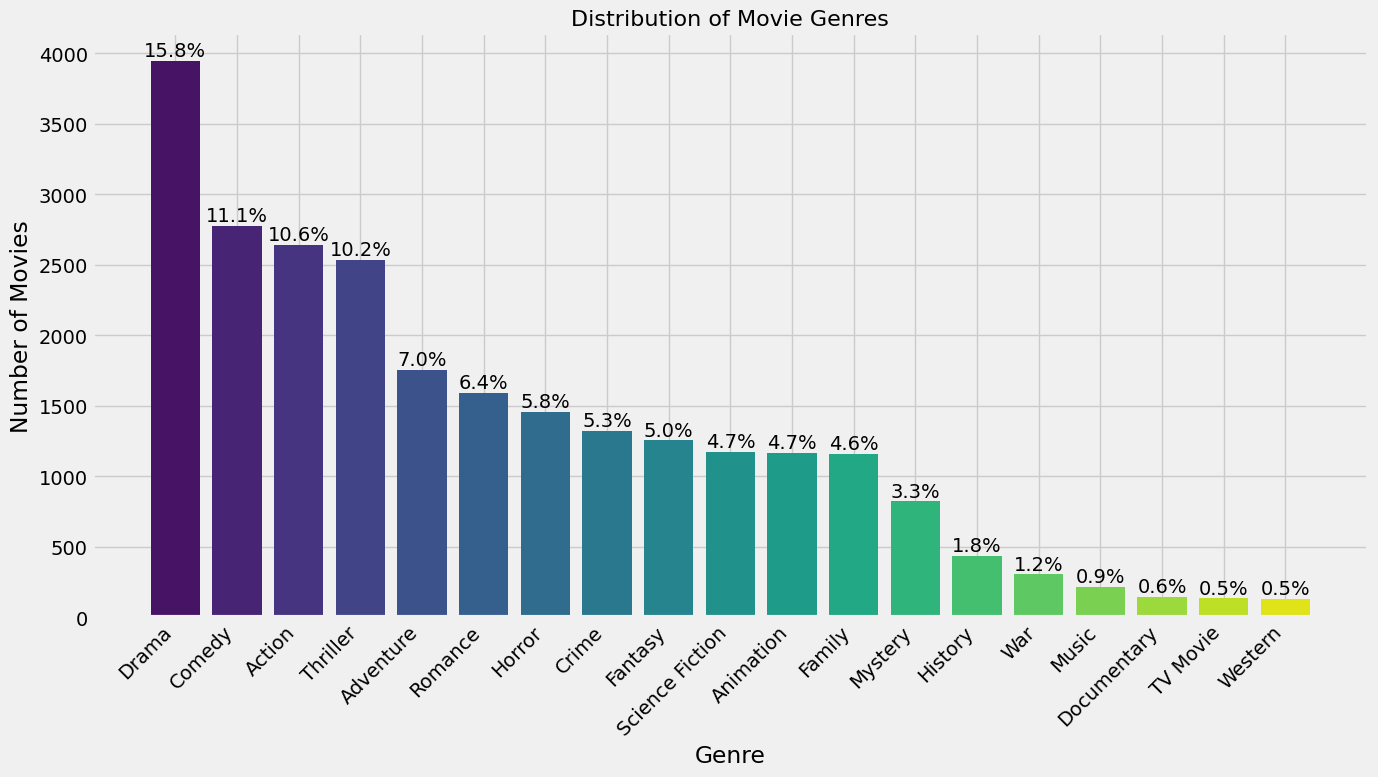

In [5]:
# Basic data cleaning and preparation
# Convert release_date to datetime
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'], errors='coerce')
movies_df['release_year'] = movies_df['release_date'].dt.year

# Create a genre map for easier reference
genre_map = {genre['id']: genre['name'] for genre in movie_genres_data}

# Extract genres for each movie
def get_genre_names(genre_ids):
    if not isinstance(genre_ids, list):
        return []
    return [genre_map.get(genre_id, 'Unknown') for genre_id in genre_ids]

movies_df['genre_names'] = movies_df['genre_ids'].apply(get_genre_names)

# Analyze genre distribution
all_genres = [genre for sublist in movies_df['genre_names'].tolist() for genre in sublist]
genre_counts = Counter(all_genres)

# Plot genre distribution
plt.figure(figsize=(14, 10))
genre_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['count']).reset_index()
genre_df = genre_df.sort_values('count', ascending=False)

plt.figure(figsize=(14, 8))
bars = plt.bar(genre_df['index'], genre_df['count'], color=sns.color_palette('viridis', len(genre_df)))
plt.xticks(rotation=45, ha='right')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movie Genres', fontsize=16)

# Add percentage on top of bars
total = genre_df['count'].sum()
for bar, count in zip(bars, genre_df['count']):
    percentage = f"{count/total*100:.1f}%"
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 5,
        percentage,
        ha='center',
        va='bottom',
        rotation=0
    )

plt.tight_layout()
plt.show()

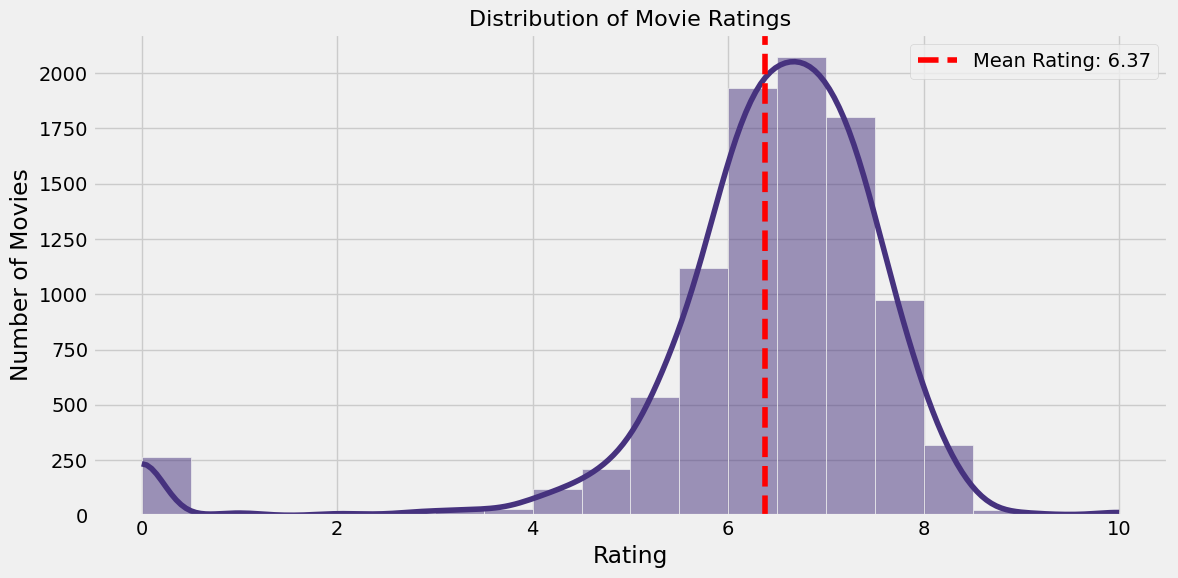

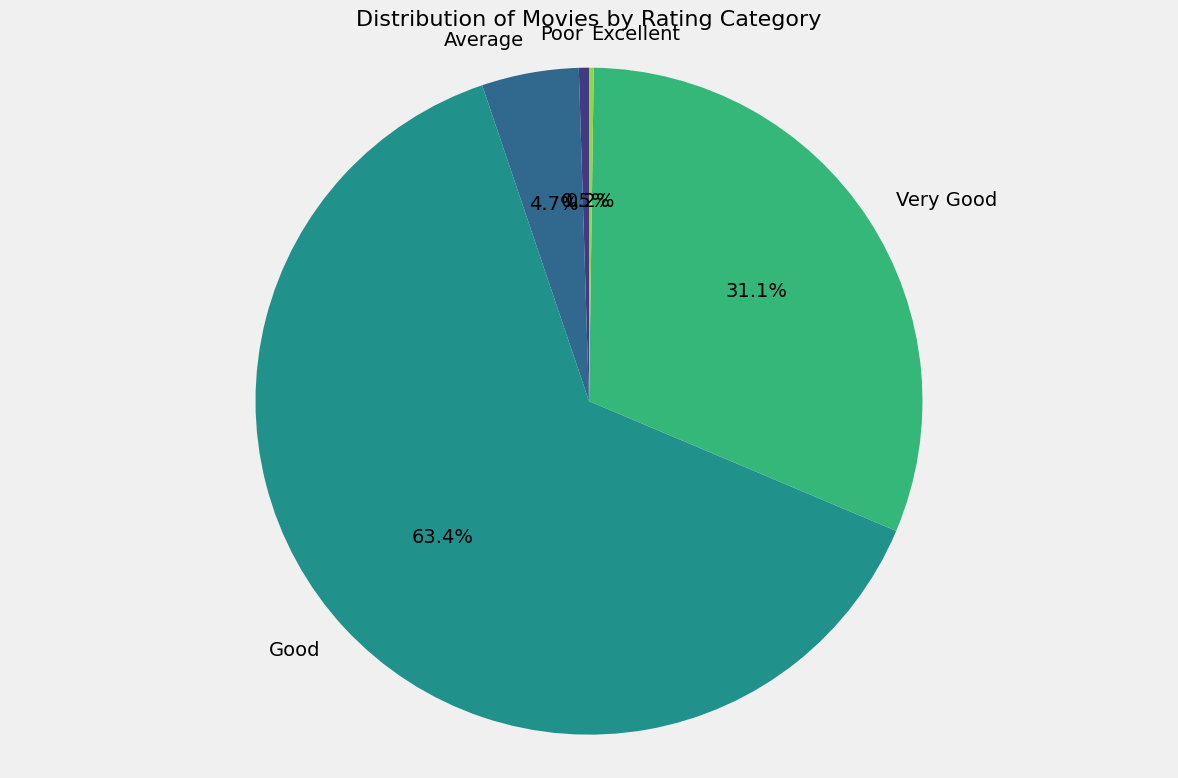

In [6]:
# Analyze rating distribution
plt.figure(figsize=(12, 6))
sns.histplot(movies_df['vote_average'], bins=20, kde=True)
plt.xlabel('Rating')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movie Ratings', fontsize=16)
plt.axvline(movies_df['vote_average'].mean(), color='red', linestyle='--', 
           label=f'Mean Rating: {movies_df["vote_average"].mean():.2f}')
plt.legend()
plt.tight_layout()
plt.show()

# Create rating buckets for visualization
movies_df['rating_bucket'] = pd.cut(movies_df['vote_average'], 
                                   bins=[0, 3, 5, 7, 9, 10], 
                                   labels=['Poor', 'Average', 
                                           'Good', 'Very Good', 
                                           'Excellent'])

plt.figure(figsize=(12, 8))
rating_counts = movies_df['rating_bucket'].value_counts().sort_index()
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', 
        startangle=90, colors=sns.color_palette('viridis', len(rating_counts)))
plt.axis('equal')
plt.title('Distribution of Movies by Rating Category', fontsize=16)
plt.tight_layout()
plt.show()

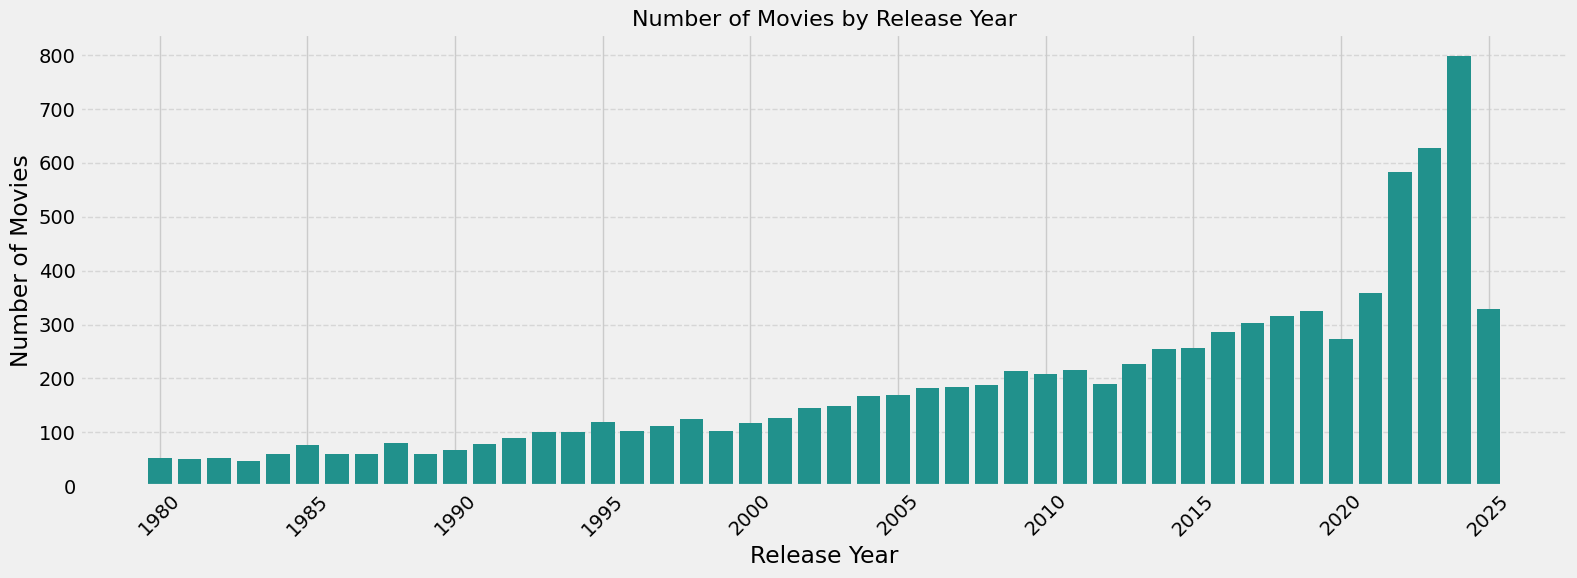

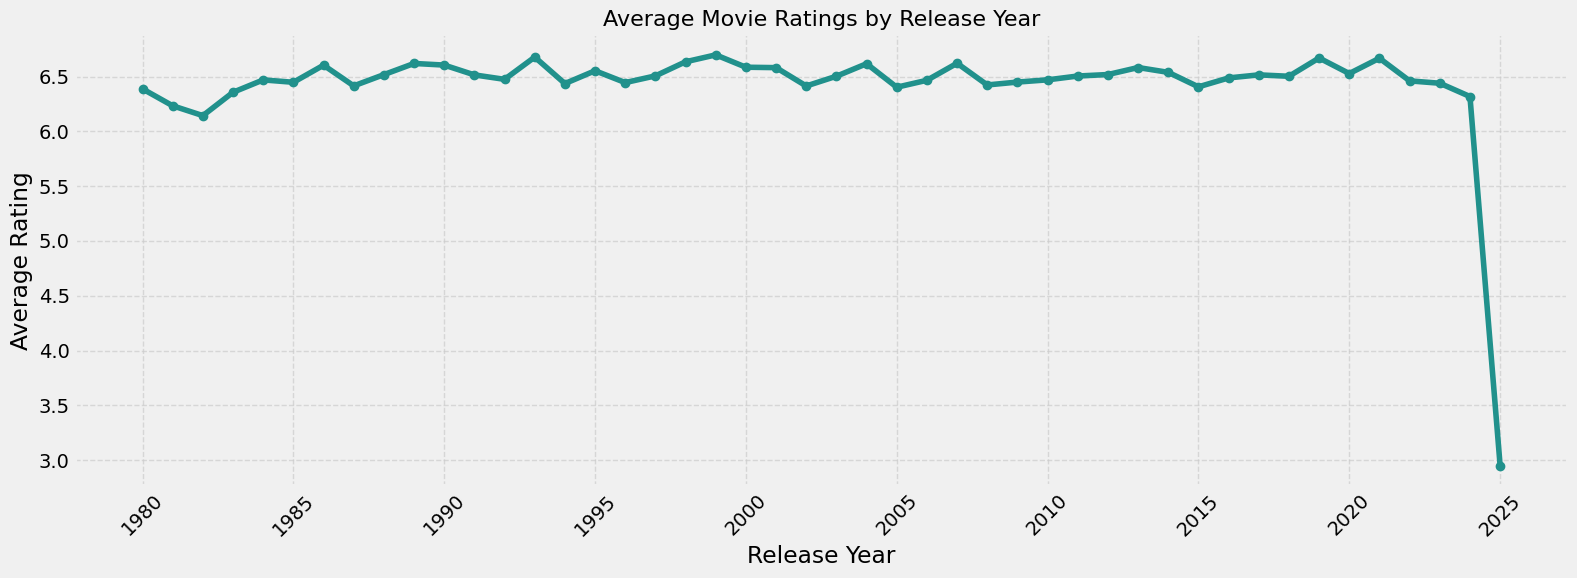

In [7]:
# Analyze movies by release year
year_counts = movies_df['release_year'].value_counts().sort_index()
year_counts = year_counts[year_counts.index >= 1980]  # Filter for recent years
year_counts = year_counts[year_counts.index <= datetime.now().year]  # Remove future years

plt.figure(figsize=(16, 6))
plt.bar(year_counts.index, year_counts.values, color=sns.color_palette('viridis', 1)[0])
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.title('Number of Movies by Release Year', fontsize=16)
plt.xticks(range(int(min(year_counts.index)), int(max(year_counts.index)) + 1, 5), rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Analyze average ratings by year
year_ratings = movies_df.groupby('release_year')['vote_average'].mean()
year_ratings = year_ratings[year_ratings.index >= 1980]
year_ratings = year_ratings[year_ratings.index <= datetime.now().year]

plt.figure(figsize=(16, 6))
plt.plot(year_ratings.index, year_ratings.values, marker='o', linestyle='-', 
         color=sns.color_palette('viridis', 1)[0])
plt.xlabel('Release Year')
plt.ylabel('Average Rating')
plt.title('Average Movie Ratings by Release Year', fontsize=16)
plt.xticks(range(int(min(year_ratings.index)), int(max(year_ratings.index))+1, 5), rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

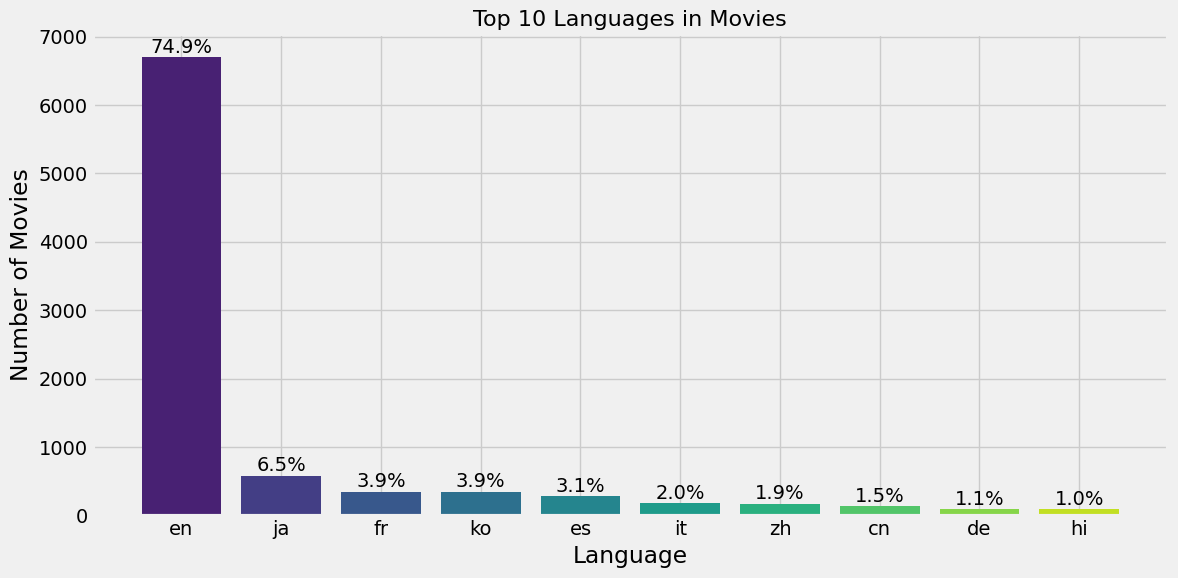

In [8]:
# Analyze language distribution
language_counts = movies_df['original_language'].value_counts().head(10)

plt.figure(figsize=(12, 6))
bars = plt.bar(language_counts.index, language_counts.values, 
        color=sns.color_palette('viridis', len(language_counts)))
plt.xlabel('Language')
plt.ylabel('Number of Movies')
plt.title('Top 10 Languages in Movies', fontsize=16)

# Add percentage on top of bars
total = language_counts.sum()
for bar, count in zip(bars, language_counts.values):
    percentage = f"{count/total*100:.1f}%"
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 5,
        percentage,
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()

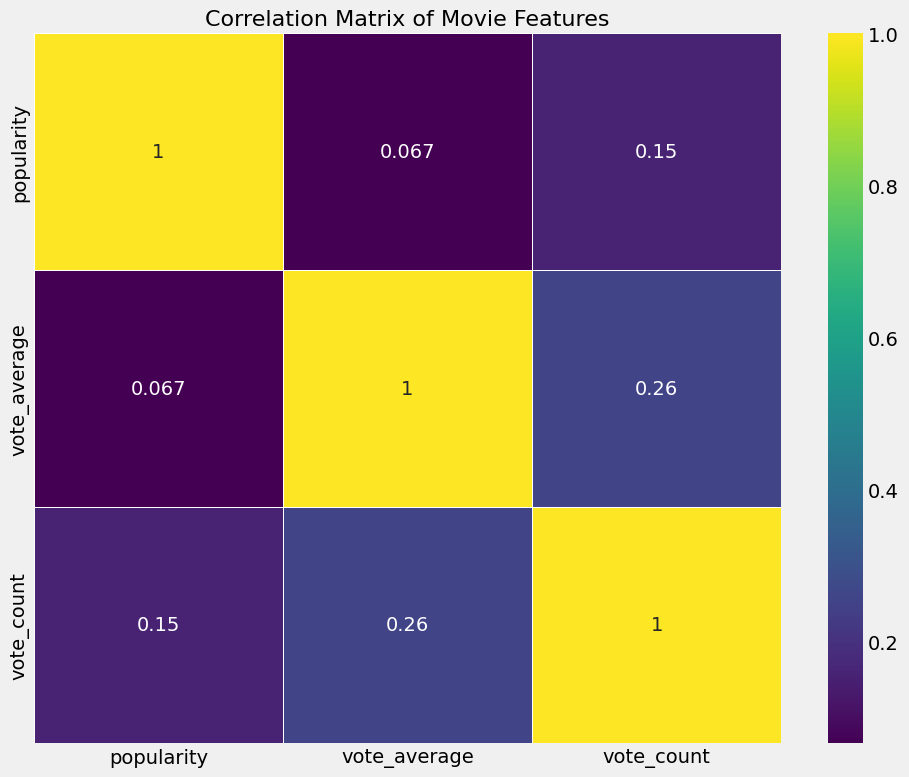

In [9]:
# Create a correlation matrix for numerical features
numeric_cols = ['popularity', 'vote_average', 'vote_count']
correlation = movies_df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='viridis', linewidths=0.5)
plt.title('Correlation Matrix of Movie Features', fontsize=16)
plt.tight_layout()
plt.show()

In [10]:

# Interactive scatter plot of vote count vs. average rating
fig = px.scatter(
    movies_df.sample(min(1000, len(movies_df))),  # Sample to avoid overcrowding
    x='vote_count',
    y='vote_average',
    size='popularity',
    color='release_year',
    hover_name='title',
    opacity=0.7,
    title='Movie Ratings vs. Vote Count',
    labels={'vote_count': 'Number of Votes', 'vote_average': 'Average Rating', 
           'release_year': 'Release Year', 'popularity': 'Popularity'},
    color_continuous_scale='viridis'
)
fig.update_layout(height=600, width=1000)
fig.show()

C:\Users\cilek\AppData\Local\Temp\ipykernel_58196\3933696918.py:24: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



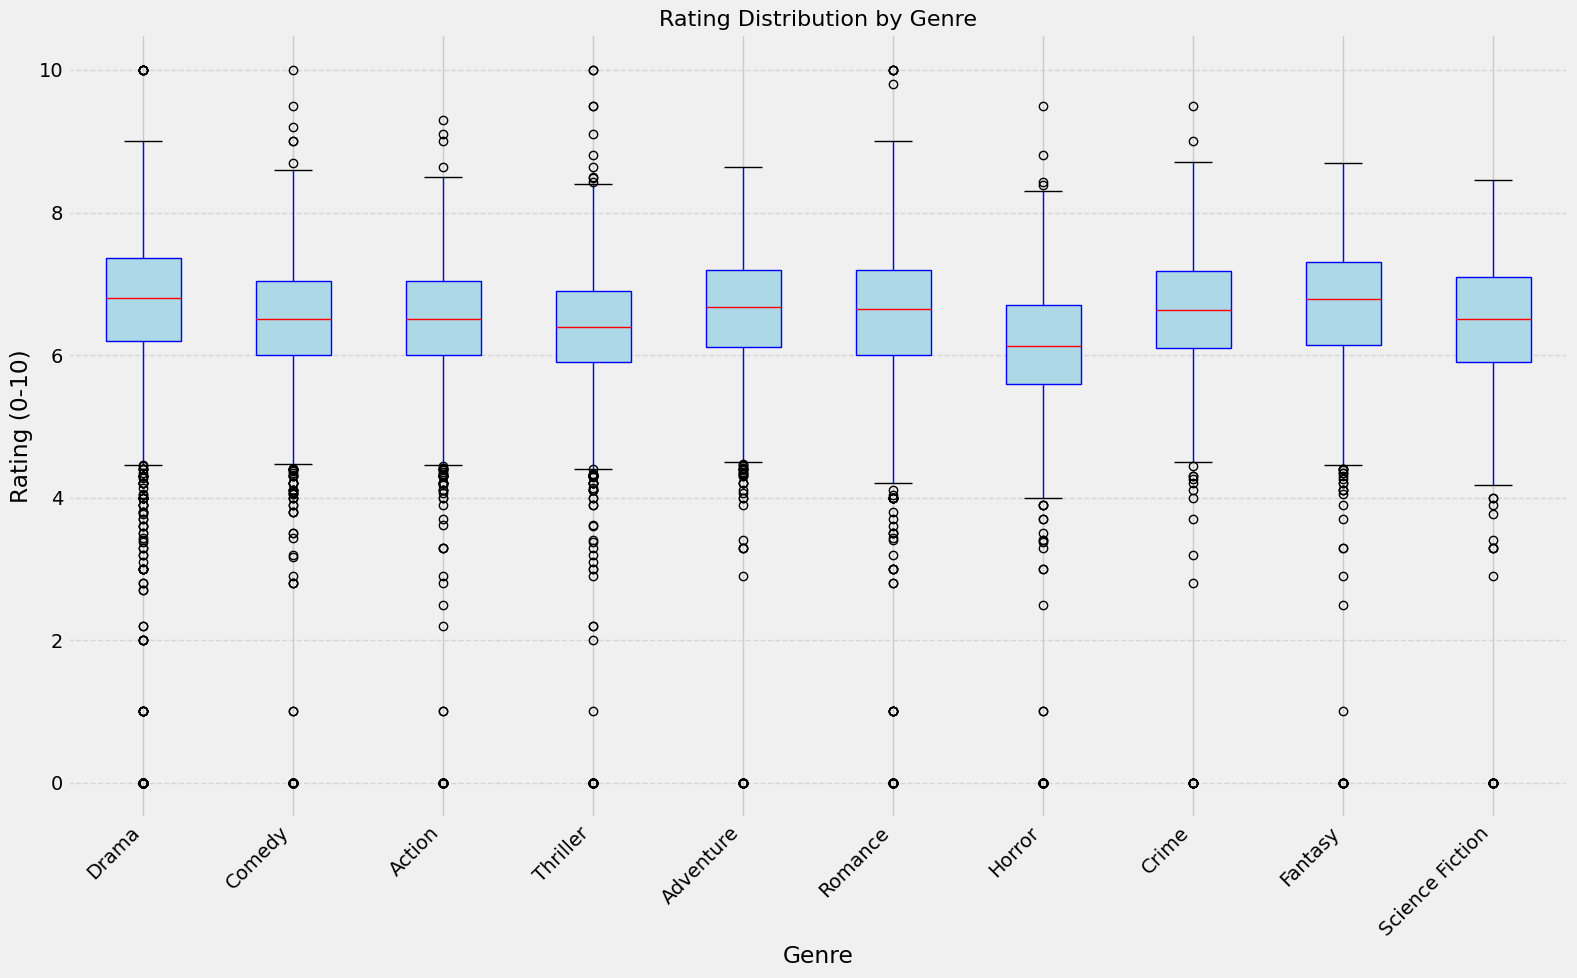

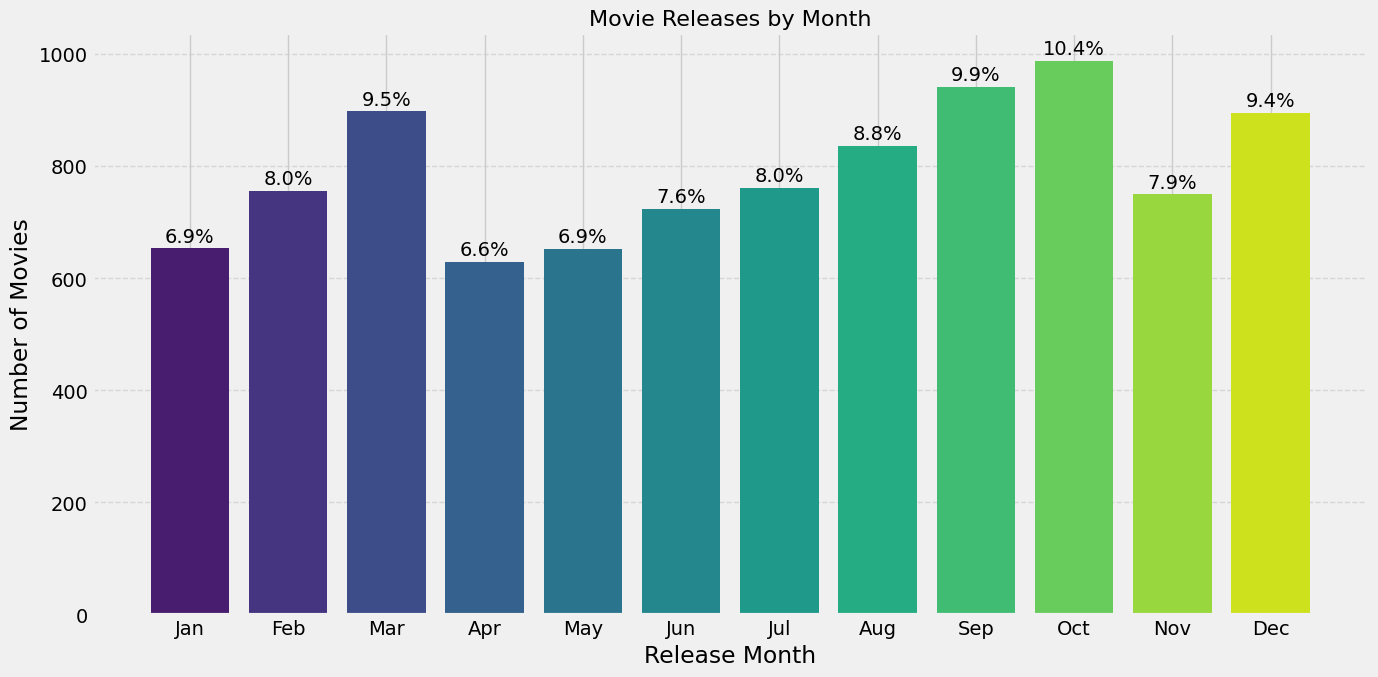

In [11]:
# Genre vs. Rating Analysis
plt.figure(figsize=(16, 10))

# Get the most common genres
top_genres = pd.DataFrame(Counter(all_genres).most_common(10), columns=['Genre', 'Count'])['Genre'].tolist()

# Create a list to store genre ratings data
genre_ratings = []

# Collect ratings for each top genre
for genre in top_genres:
    # Find all movies containing this genre
    genre_movies = movies_df[movies_df['genre_names'].apply(lambda x: genre in x)]
    # Store the genre and its ratings
    genre_ratings.append({
        'genre': genre,
        'ratings': genre_movies['vote_average'].tolist()
    })

# Create boxplot
box_data = [item['ratings'] for item in genre_ratings]
box_labels = [item['genre'] for item in genre_ratings]

plt.boxplot(box_data, labels=box_labels, patch_artist=True, 
           boxprops=dict(facecolor='lightblue', color='blue'),
           whiskerprops=dict(color='blue'),
           medianprops=dict(color='red'))

plt.title('Rating Distribution by Genre', fontsize=16)
plt.ylabel('Rating (0-10)')
plt.xlabel('Genre')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Seasonal release patterns
movies_df['release_month'] = movies_df['release_date'].dt.month
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_counts = movies_df['release_month'].value_counts().sort_index()

plt.figure(figsize=(14, 7))
bars = plt.bar(range(1, 13), [month_counts.get(i, 0) for i in range(1, 13)], color=sns.color_palette('viridis', 12))
plt.xticks(range(1, 13), month_names)
plt.xlabel('Release Month')
plt.ylabel('Number of Movies')
plt.title('Movie Releases by Month', fontsize=16)

# Add percentage on top of bars
total = month_counts.sum()
for bar, count in zip(bars, [month_counts.get(i, 0) for i in range(1, 13)]):
    percentage = f"{count/total*100:.1f}%"
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 5,
        percentage,
        ha='center',
        va='bottom'
    )

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [12]:
# Exploring detailed movie data
detailed_movies = list(db.detailed_movies.find())
detailed_movies_df = pd.DataFrame(detailed_movies)

print(f"Number of movies with detailed information: {len(detailed_movies_df)}")
print(f"Columns in detailed movies data: {detailed_movies_df.columns.tolist()}")

# Display sample of detailed movie data
detailed_movies_df.iloc[0].head(10)

Number of movies with detailed information: 9464
Columns in detailed movies data: ['_id', 'adult', 'backdrop_path', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'imdb_id', 'origin_country', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'vote_average', 'vote_count', 'credits', 'keywords', 'similar', 'videos']


_id                                               67d8210f6df8a70f77505b5f
adult                                                                False
backdrop_path                             /9nhjGaFLKtddDPtPaX5EmKqsWdH.jpg
belongs_to_collection                                                 None
budget                                                                   0
genres                   [{'id': 10749, 'name': 'Romance'}, {'id': 878,...
homepage                 https://tv.apple.com/movie/umc.cmc.26o403koqo2...
id                                                                  950396
imdb_id                                                         tt13654226
origin_country                                                        [US]
Name: 0, dtype: object

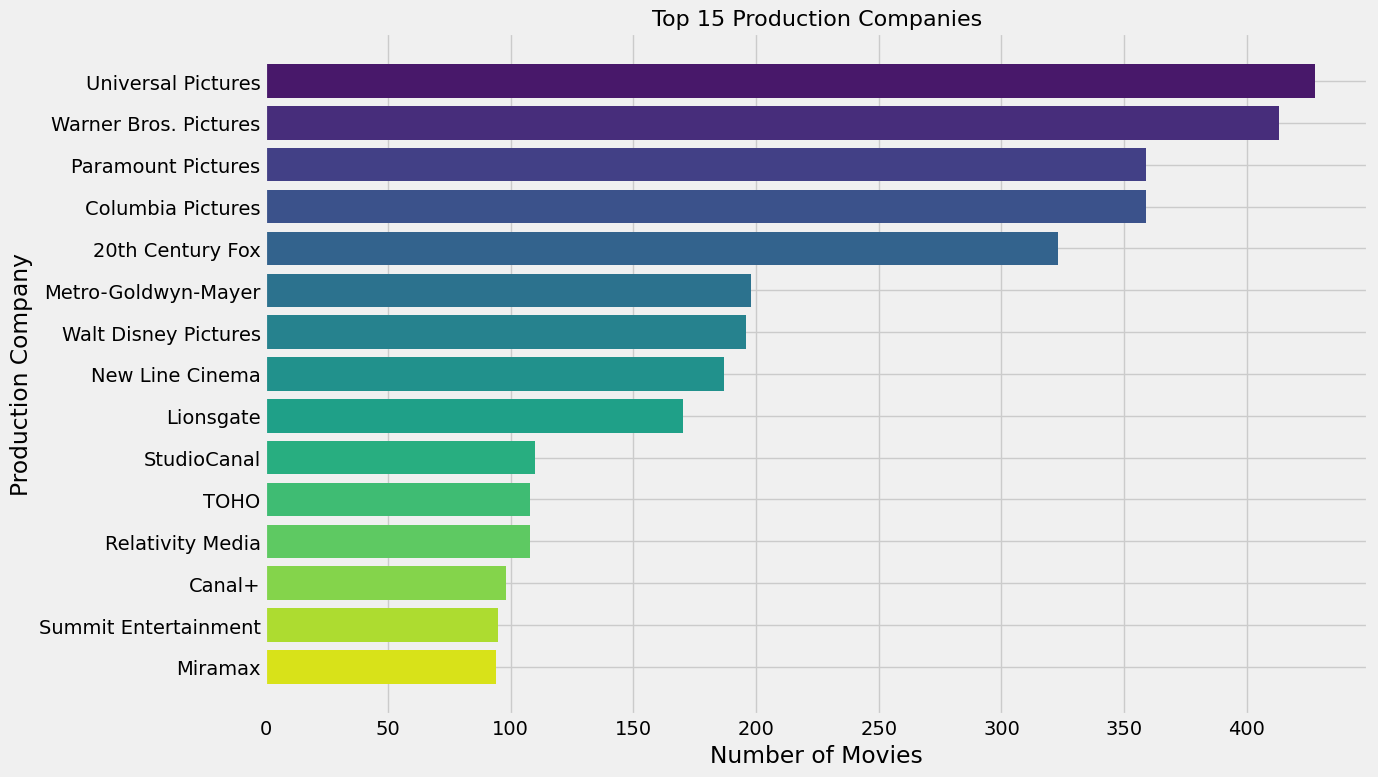

C:\Users\cilek\AppData\Local\Temp\ipykernel_58196\3707143905.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



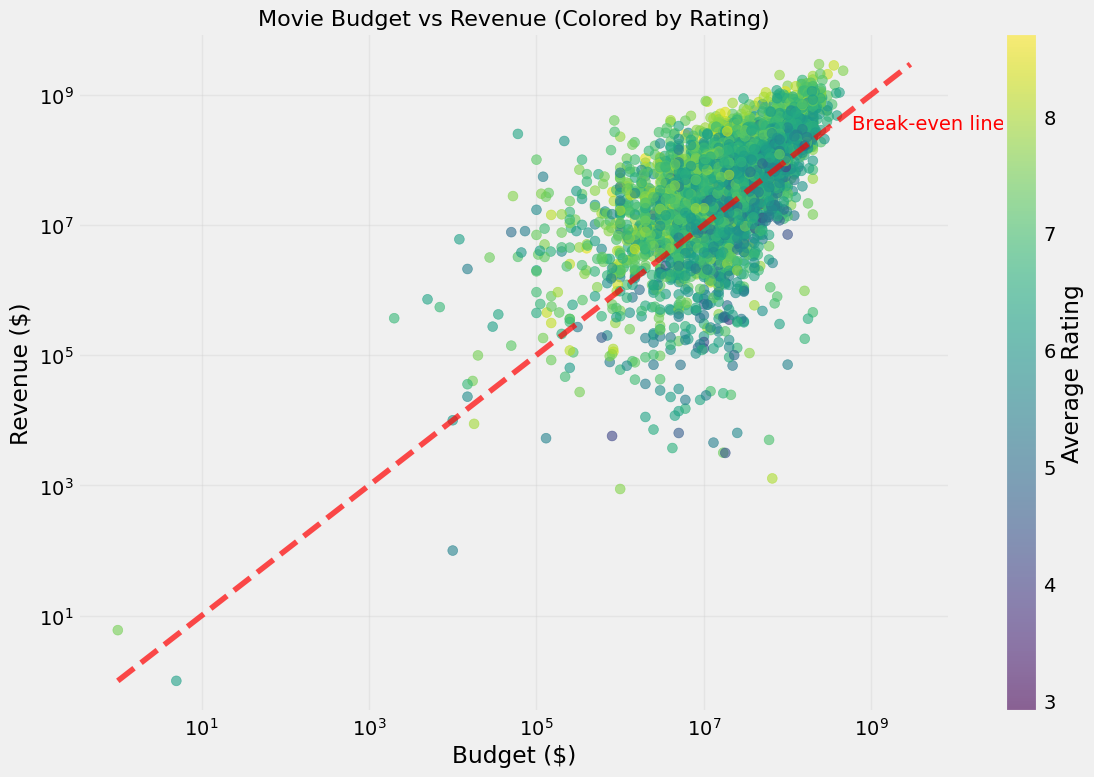

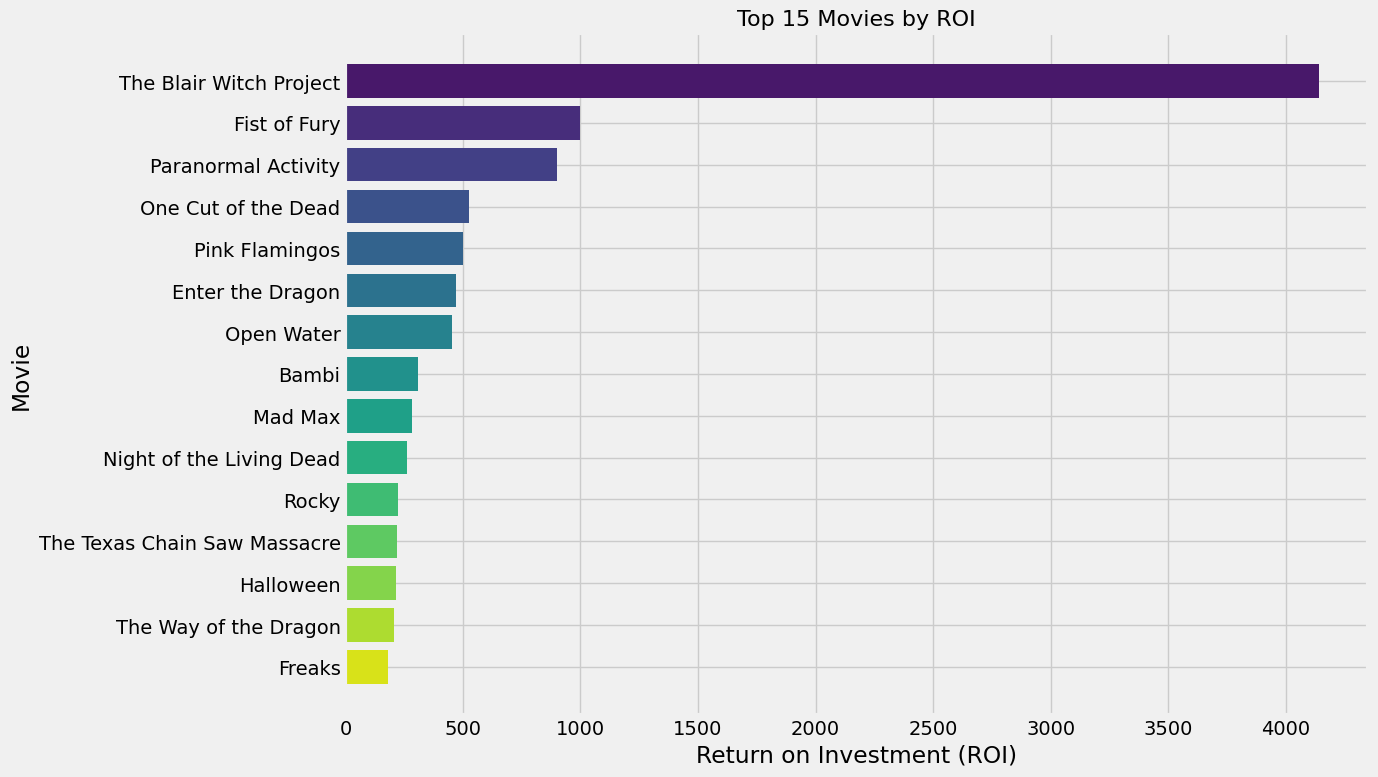

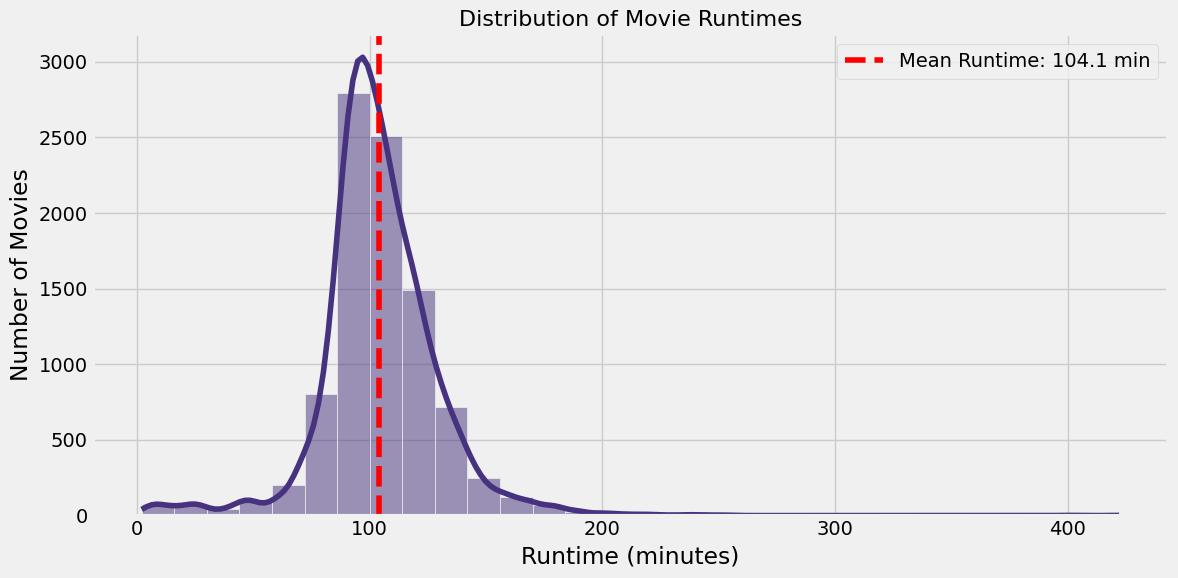

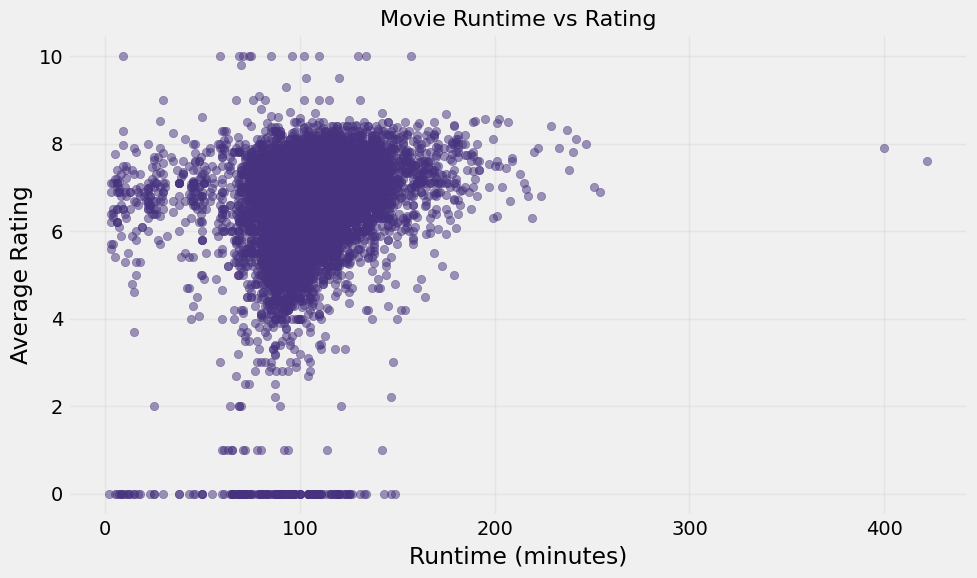

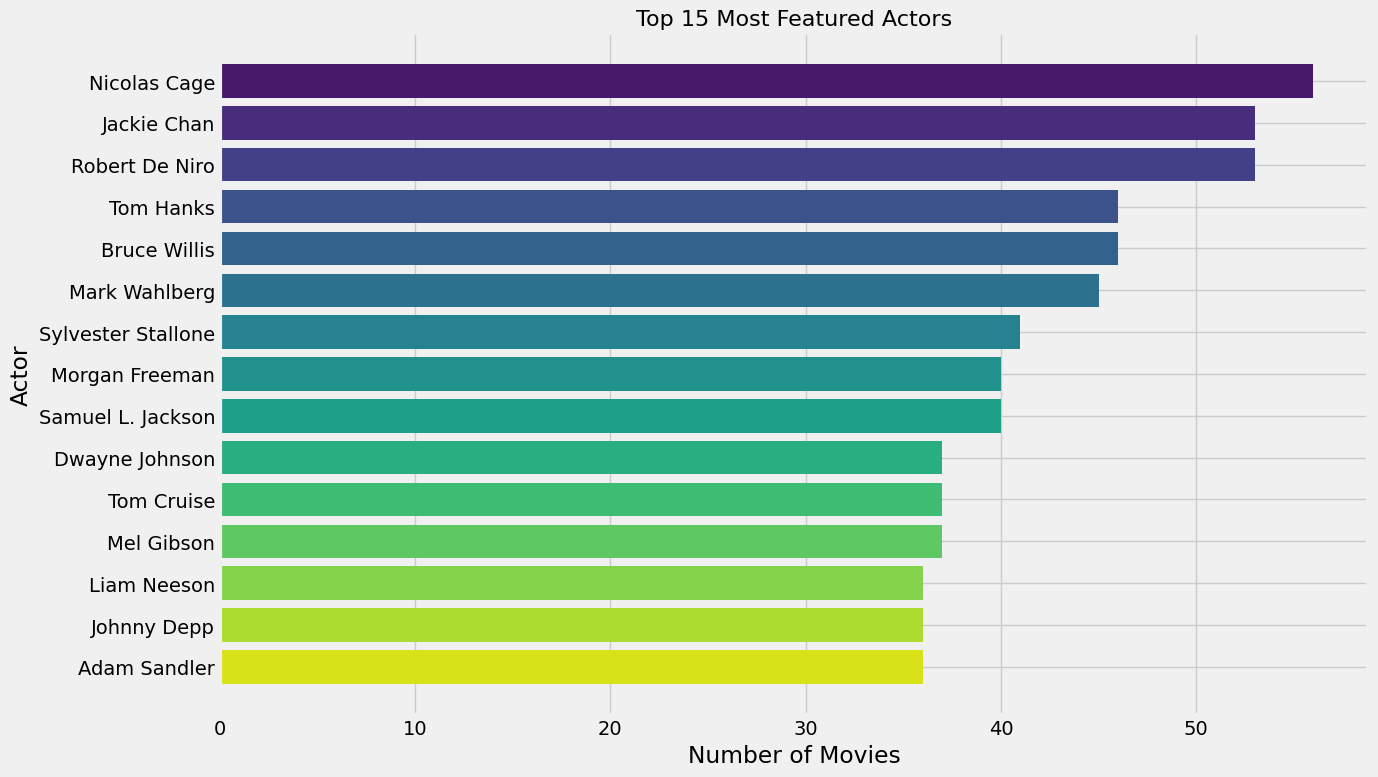

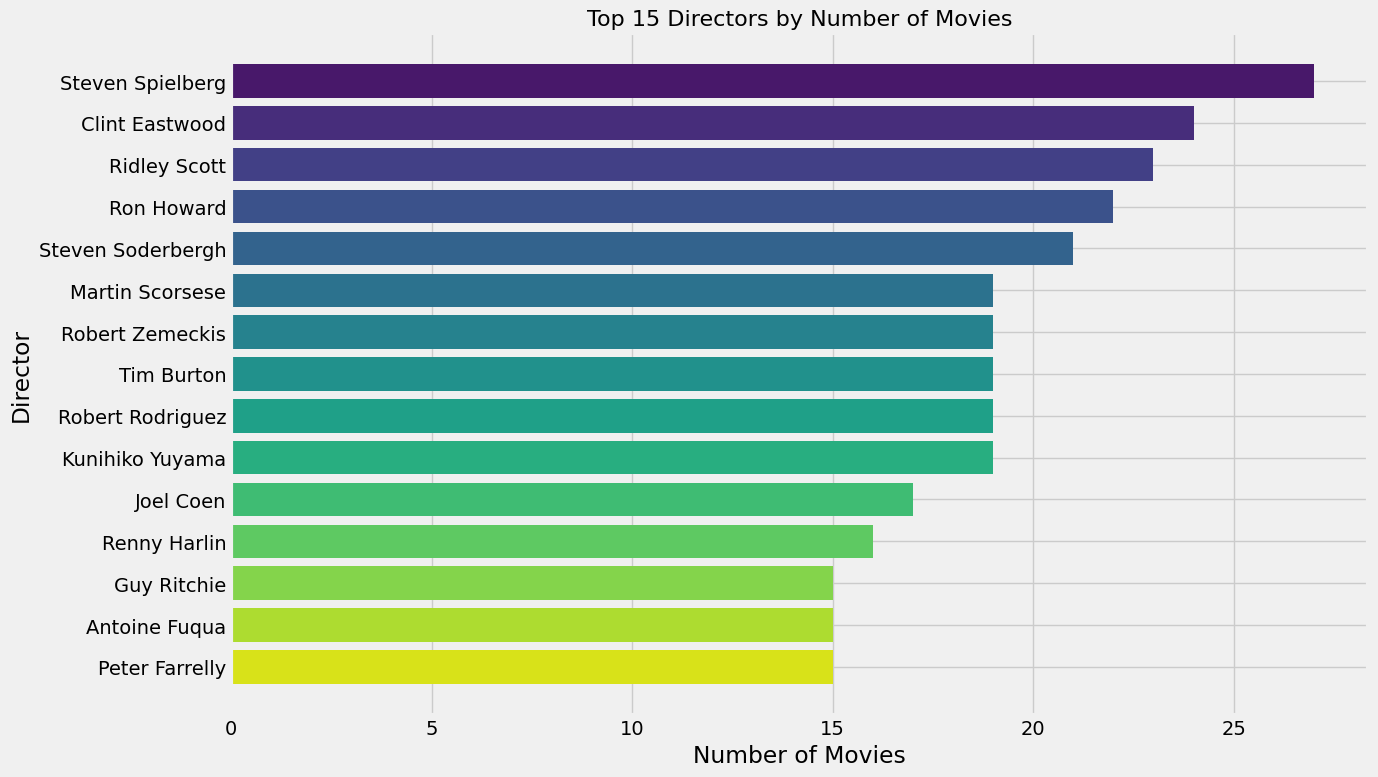

In [13]:
# Analyze production companies
if 'production_companies' in detailed_movies_df.columns:
    # Extract production company names
    all_companies = []
    for companies in detailed_movies_df['production_companies']:
        if isinstance(companies, list):
            for company in companies:
                if isinstance(company, dict) and 'name' in company:
                    all_companies.append(company['name'])
    
    # Count companies
    company_counts = Counter(all_companies).most_common(15)
    company_df = pd.DataFrame(company_counts, columns=['Company', 'Count'])
    
    plt.figure(figsize=(14, 8))
    bars = plt.barh(company_df['Company'], company_df['Count'], 
                    color=sns.color_palette('viridis', len(company_df)))
    plt.xlabel('Number of Movies')
    plt.ylabel('Production Company')
    plt.title('Top 15 Production Companies', fontsize=16)
    plt.gca().invert_yaxis()  # Invert y-axis to show most common at top
    plt.tight_layout()
    plt.show()

# Analyze movie budgets and revenues
if 'budget' in detailed_movies_df.columns and 'revenue' in detailed_movies_df.columns:
    # Filter out zero budgets and revenues
    budget_revenue_df = detailed_movies_df[(detailed_movies_df['budget'] > 0) & 
                                          (detailed_movies_df['revenue'] > 0)]
    
    # Calculate ROI (Return on Investment)
    budget_revenue_df['roi'] = (budget_revenue_df['revenue'] - budget_revenue_df['budget']) / budget_revenue_df['budget']
    
    # Plot budget vs revenue
    plt.figure(figsize=(12, 8))
    plt.scatter(budget_revenue_df['budget'], budget_revenue_df['revenue'], 
                alpha=0.6, c=budget_revenue_df['vote_average'], cmap='viridis', s=50)
    plt.colorbar(label='Average Rating')
    plt.xlabel('Budget ($)')
    plt.ylabel('Revenue ($)')
    plt.title('Movie Budget vs Revenue (Colored by Rating)', fontsize=16)
    plt.xscale('log')
    plt.yscale('log')
    
    # Add reference line for break-even
    max_val = max(budget_revenue_df['budget'].max(), budget_revenue_df['revenue'].max())
    plt.plot([1, max_val], [1, max_val], 'r--', alpha=0.7)
    plt.annotate('Break-even line', xy=(max_val/10, max_val/10), 
                 xytext=(max_val/5, max_val/10), 
                 arrowprops=dict(arrowstyle='->'), color='red')
    
    plt.tight_layout()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Plot top ROI movies
    top_roi = budget_revenue_df.sort_values('roi', ascending=False).head(15)
    plt.figure(figsize=(14, 8))
    bars = plt.barh(top_roi['title'], top_roi['roi'], color=sns.color_palette('viridis', len(top_roi)))
    plt.xlabel('Return on Investment (ROI)')
    plt.ylabel('Movie')
    plt.title('Top 15 Movies by ROI', fontsize=16)
    plt.gca().invert_yaxis()  # Invert y-axis to show highest ROI at top
    plt.tight_layout()
    plt.show()

# Analyze runtime distribution
if 'runtime' in detailed_movies_df.columns:
    # Filter out null runtimes
    runtime_df = detailed_movies_df[detailed_movies_df['runtime'] > 0]
    
    plt.figure(figsize=(12, 6))
    sns.histplot(runtime_df['runtime'], bins=30, kde=True)
    plt.axvline(runtime_df['runtime'].mean(), color='red', linestyle='--', 
               label=f'Mean Runtime: {runtime_df["runtime"].mean():.1f} min')
    plt.xlabel('Runtime (minutes)')
    plt.ylabel('Number of Movies')
    plt.title('Distribution of Movie Runtimes', fontsize=16)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Analyze runtime vs rating
    plt.figure(figsize=(10, 6))
    plt.scatter(runtime_df['runtime'], runtime_df['vote_average'], alpha=0.5)
    plt.xlabel('Runtime (minutes)')
    plt.ylabel('Average Rating')
    plt.title('Movie Runtime vs Rating', fontsize=16)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Analyze movie credits/cast
if 'credits' in detailed_movies_df.columns and isinstance(detailed_movies_df['credits'].iloc[0], dict):
    # Extract top actors
    all_actors = []
    for _, movie in detailed_movies_df.iterrows():
        if isinstance(movie['credits'], dict) and 'cast' in movie['credits']:
            for actor in movie['credits']['cast'][:3]:  # Consider top 3 actors per movie
                if isinstance(actor, dict) and 'name' in actor:
                    all_actors.append(actor['name'])
    
    # Count actors
    actor_counts = Counter(all_actors).most_common(15)
    actor_df = pd.DataFrame(actor_counts, columns=['Actor', 'Count'])
    
    plt.figure(figsize=(14, 8))
    bars = plt.barh(actor_df['Actor'], actor_df['Count'], color=sns.color_palette('viridis', len(actor_df)))
    plt.xlabel('Number of Movies')
    plt.ylabel('Actor')
    plt.title('Top 15 Most Featured Actors', fontsize=16)
    plt.gca().invert_yaxis()  # Invert y-axis to show most common at top
    plt.tight_layout()
    plt.show()
    
    # Extract top directors
    all_directors = []
    for _, movie in detailed_movies_df.iterrows():
        if isinstance(movie['credits'], dict) and 'crew' in movie['credits']:
            for crew_member in movie['credits']['crew']:
                if isinstance(crew_member, dict) and crew_member.get('job') == 'Director':
                    all_directors.append(crew_member.get('name'))
    
    # Count directors
    director_counts = Counter(all_directors).most_common(15)
    director_df = pd.DataFrame(director_counts, columns=['Director', 'Count'])
    
    plt.figure(figsize=(14, 8))
    bars = plt.barh(director_df['Director'], director_df['Count'], 
                   color=sns.color_palette('viridis', len(director_df)))
    plt.xlabel('Number of Movies')
    plt.ylabel('Director')
    plt.title('Top 15 Directors by Number of Movies', fontsize=16)
    plt.gca().invert_yaxis()  # Invert y-axis to show most common at top
    plt.tight_layout()
    plt.show()

In [14]:
# TV SERIES ANALYSIS
print("\n" + "="*50)
print("TV SERIES ANALYSIS")
print("="*50)

# Basic cleaning and preparation for series data
# Convert first_air_date to datetime
series_df['first_air_date'] = pd.to_datetime(series_df['first_air_date'], errors='coerce')
series_df['release_year'] = series_df['first_air_date'].dt.year

# Get TV genre map
tv_genres_data = list(db.tv_genres.find())
tv_genre_map = {genre['id']: genre['name'] for genre in tv_genres_data}

# Extract genres for each series
def get_tv_genre_names(genre_ids):
    if not isinstance(genre_ids, list):
        return []
    return [tv_genre_map.get(genre_id, 'Unknown') for genre_id in genre_ids]

series_df['genre_names'] = series_df['genre_ids'].apply(get_tv_genre_names)

# Display basic information
print(f"Number of TV series: {len(series_df)}")
print(f"Columns in series data: {series_df.columns.tolist()}")


TV SERIES ANALYSIS
Number of TV series: 8055
Columns in series data: ['_id', 'adult', 'backdrop_path', 'genre_ids', 'id', 'origin_country', 'original_language', 'original_name', 'overview', 'popularity', 'poster_path', 'first_air_date', 'name', 'vote_average', 'vote_count', 'release_year', 'genre_names']


<Figure size 1400x1000 with 0 Axes>

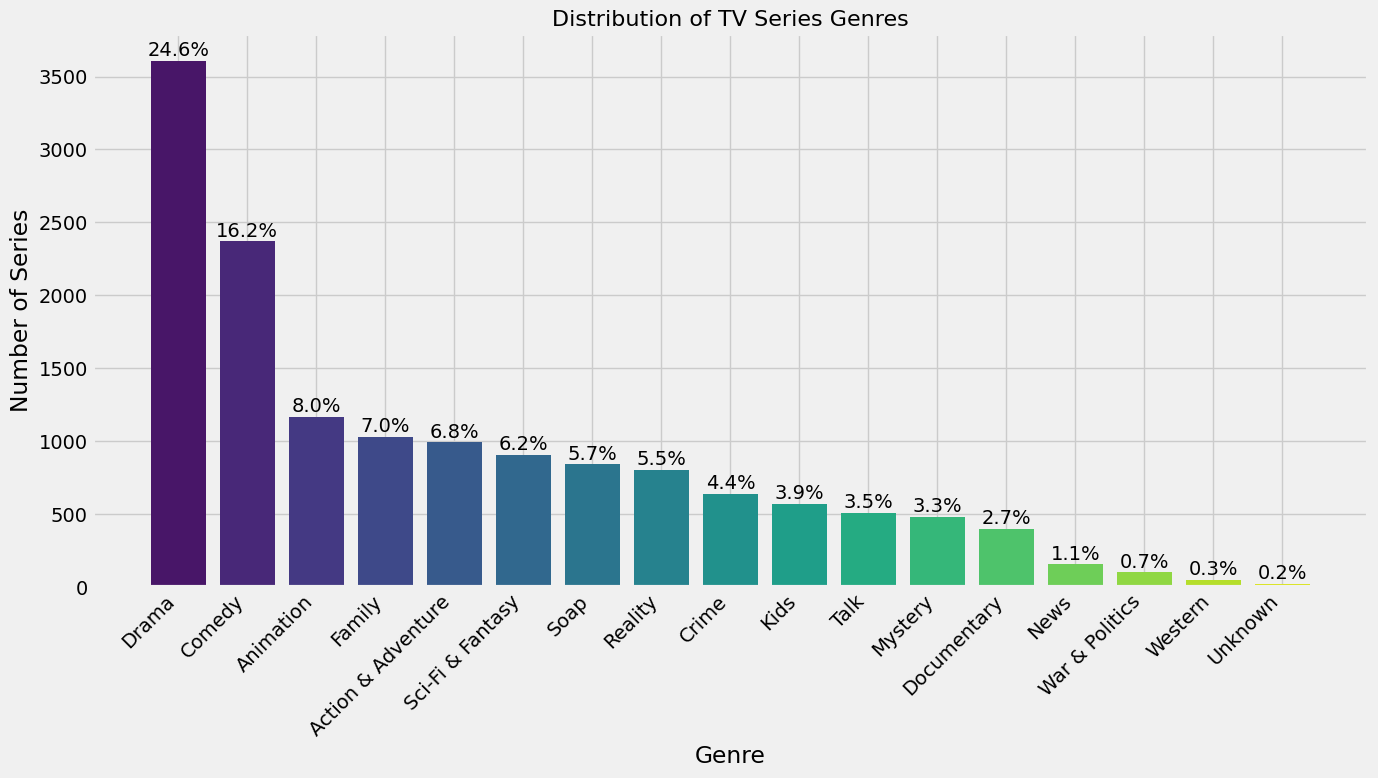

In [15]:
# Analyze TV series genre distribution
all_series_genres = [genre for sublist in series_df['genre_names'].tolist() for genre in sublist]
series_genre_counts = Counter(all_series_genres)

plt.figure(figsize=(14, 10))
series_genre_df = pd.DataFrame.from_dict(series_genre_counts, orient='index', columns=['count']).reset_index()
series_genre_df = series_genre_df.sort_values('count', ascending=False)

plt.figure(figsize=(14, 8))
bars = plt.bar(series_genre_df['index'], series_genre_df['count'], 
              color=sns.color_palette('viridis', len(series_genre_df)))
plt.xticks(rotation=45, ha='right')
plt.xlabel('Genre')
plt.ylabel('Number of Series')
plt.title('Distribution of TV Series Genres', fontsize=16)

# Add percentage on top of bars
total = series_genre_df['count'].sum()
for bar, count in zip(bars, series_genre_df['count']):
    percentage = f"{count/total*100:.1f}%"
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 5,
        percentage,
        ha='center',
        va='bottom',
        rotation=0
    )

plt.tight_layout()
plt.show()

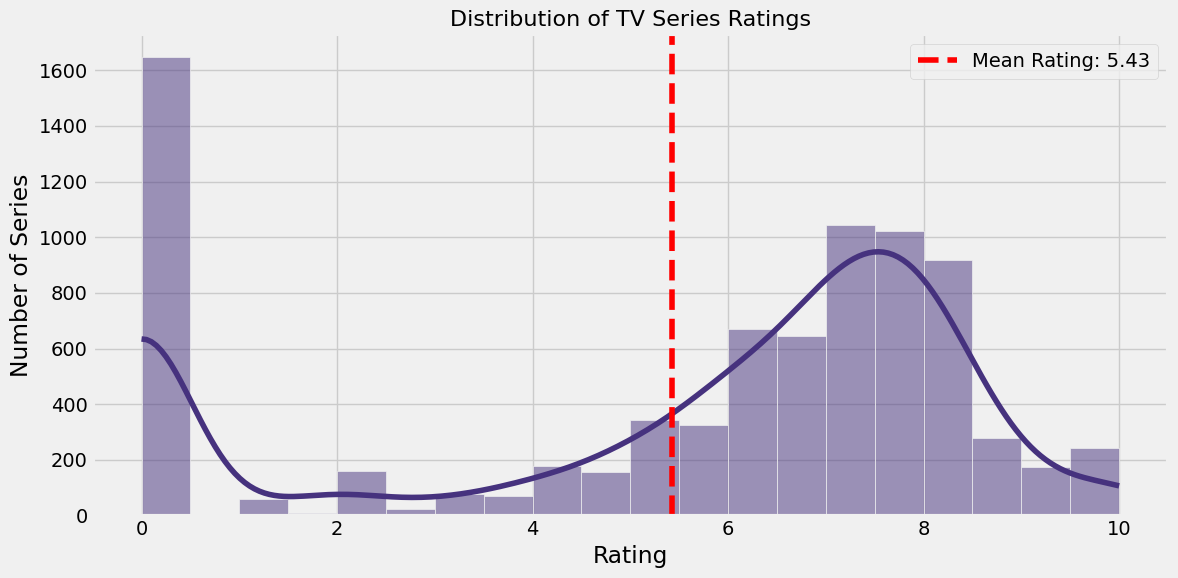

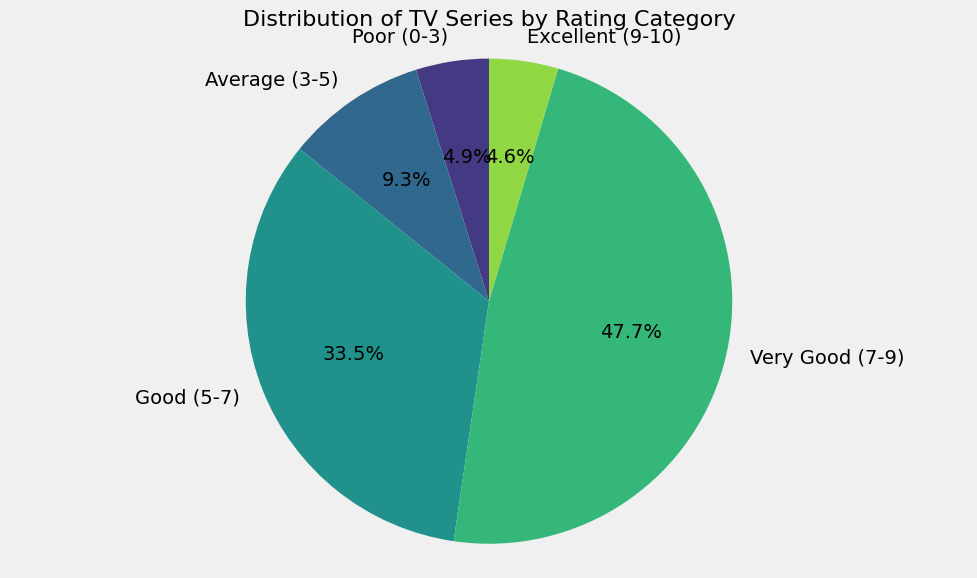

In [16]:
# Analyze TV series rating distribution
plt.figure(figsize=(12, 6))
sns.histplot(series_df['vote_average'], bins=20, kde=True)
plt.xlabel('Rating')
plt.ylabel('Number of Series')
plt.title('Distribution of TV Series Ratings', fontsize=16)
plt.axvline(series_df['vote_average'].mean(), color='red', linestyle='--', 
           label=f'Mean Rating: {series_df["vote_average"].mean():.2f}')
plt.legend()
plt.tight_layout()
plt.show()

# Create rating buckets for visualization
series_df['rating_bucket'] = pd.cut(series_df['vote_average'], 
                                   bins=[0, 3, 5, 7, 9, 10], 
                                   labels=['Poor (0-3)', 'Average (3-5)', 
                                           'Good (5-7)', 'Very Good (7-9)', 
                                           'Excellent (9-10)'])

plt.figure(figsize=(10, 6))
series_rating_counts = series_df['rating_bucket'].value_counts().sort_index()
plt.pie(series_rating_counts, labels=series_rating_counts.index, autopct='%1.1f%%', 
        startangle=90, colors=sns.color_palette('viridis', len(series_rating_counts)))
plt.axis('equal')
plt.title('Distribution of TV Series by Rating Category', fontsize=16)
plt.tight_layout()
plt.show()

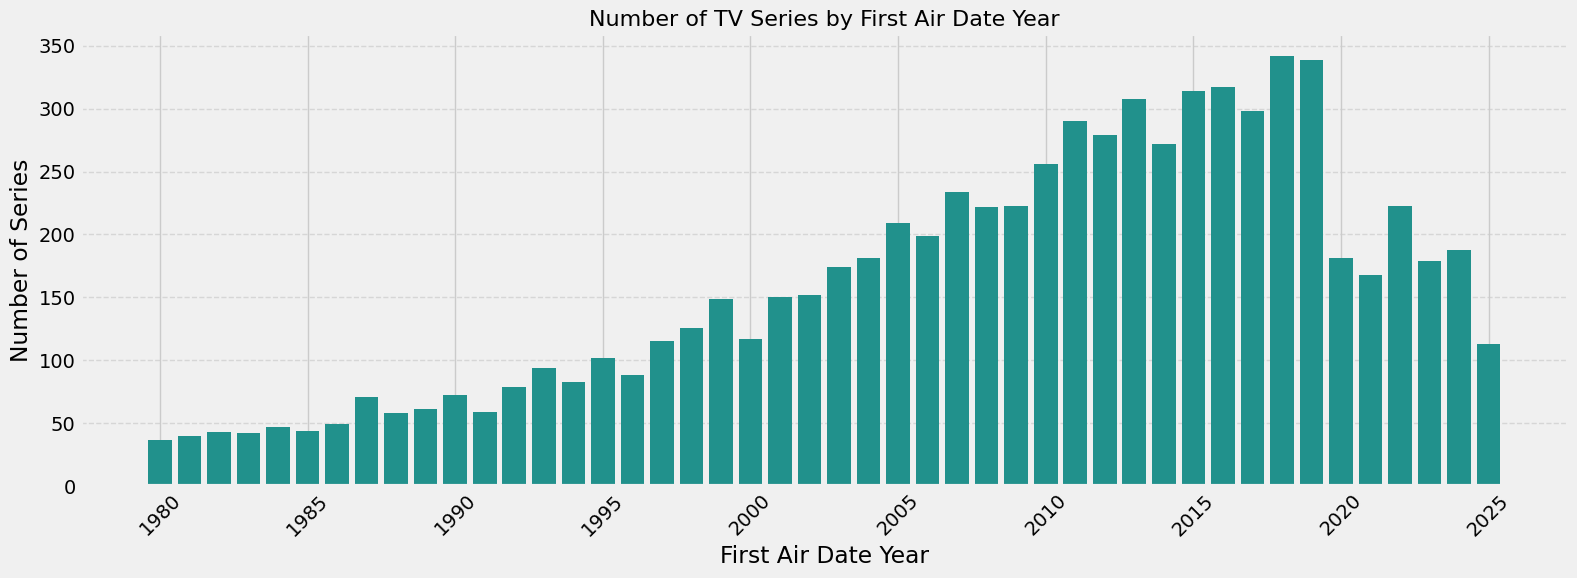

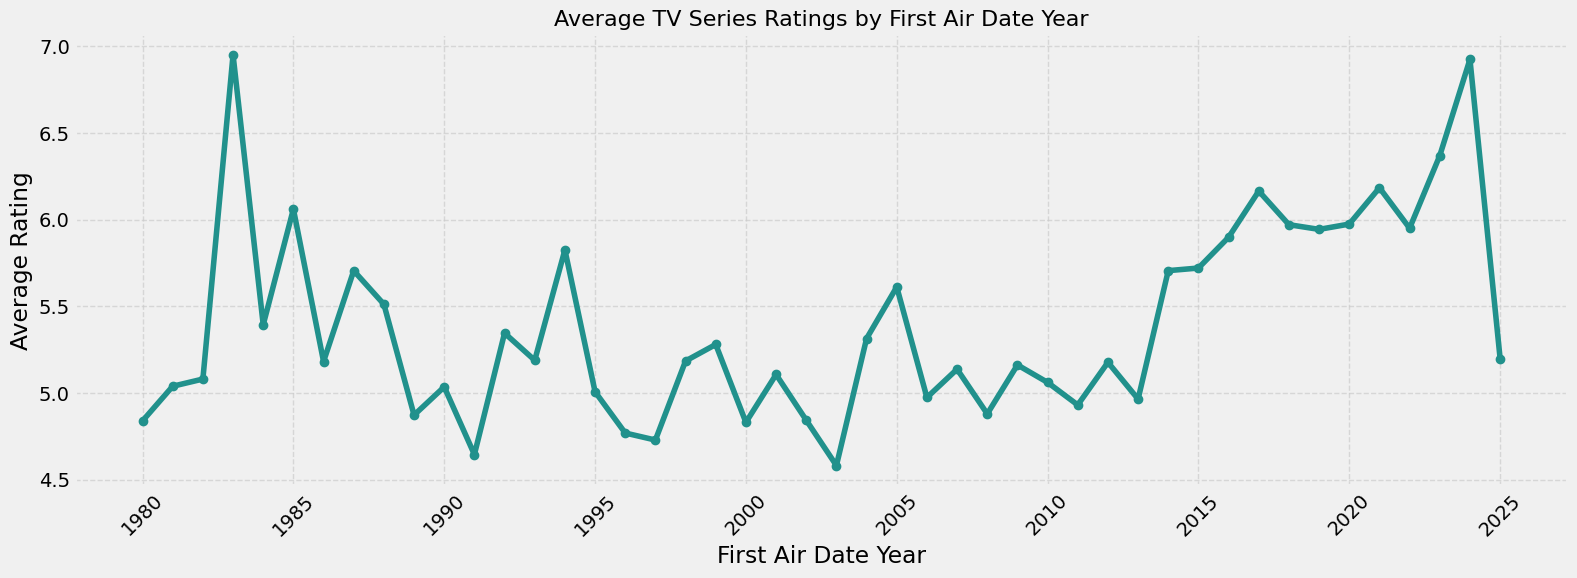

In [17]:
# Analyze series by release year
series_year_counts = series_df['release_year'].value_counts().sort_index()
series_year_counts = series_year_counts[series_year_counts.index >= 1980]
series_year_counts = series_year_counts[series_year_counts.index <= datetime.now().year]

plt.figure(figsize=(16, 6))
plt.bar(series_year_counts.index, series_year_counts.values, 
       color=sns.color_palette('viridis', 1)[0])
plt.xlabel('First Air Date Year')
plt.ylabel('Number of Series')
plt.title('Number of TV Series by First Air Date Year', fontsize=16)
plt.xticks(range(int(min(series_year_counts.index)), int(max(series_year_counts.index))+1, 5), rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Analyze average ratings by year
series_year_ratings = series_df.groupby('release_year')['vote_average'].mean()
series_year_ratings = series_year_ratings[series_year_ratings.index >= 1980]
series_year_ratings = series_year_ratings[series_year_ratings.index <= datetime.now().year]

plt.figure(figsize=(16, 6))
plt.plot(series_year_ratings.index, series_year_ratings.values, marker='o', linestyle='-', 
         color=sns.color_palette('viridis', 1)[0])
plt.xlabel('First Air Date Year')
plt.ylabel('Average Rating')
plt.title('Average TV Series Ratings by First Air Date Year', fontsize=16)
plt.xticks(range(int(min(series_year_ratings.index)), int(max(series_year_ratings.index)) + 1, 5), rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

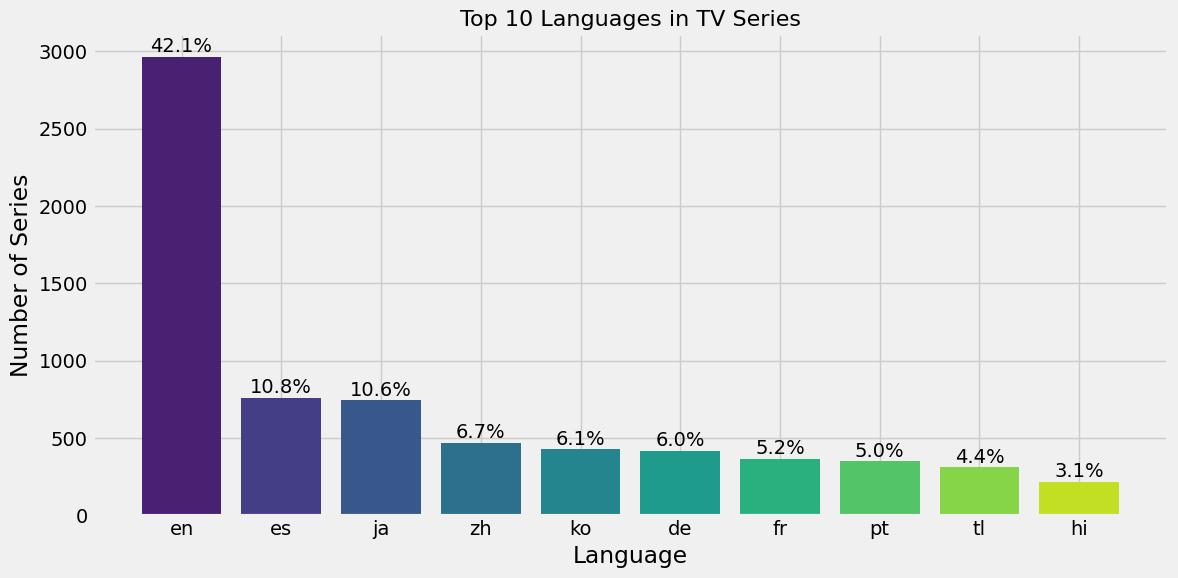

In [18]:
# Analyze language distribution for TV series
series_language_counts = series_df['original_language'].value_counts().head(10)

plt.figure(figsize=(12, 6))
bars = plt.bar(series_language_counts.index, series_language_counts.values, 
        color=sns.color_palette('viridis', len(series_language_counts)))
plt.xlabel('Language')
plt.ylabel('Number of Series')
plt.title('Top 10 Languages in TV Series', fontsize=16)

# Add percentage on top of bars
total = series_language_counts.sum()
for bar, count in zip(bars, series_language_counts.values):
    percentage = f"{count/total*100:.1f}%"
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 5,
        percentage,
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()

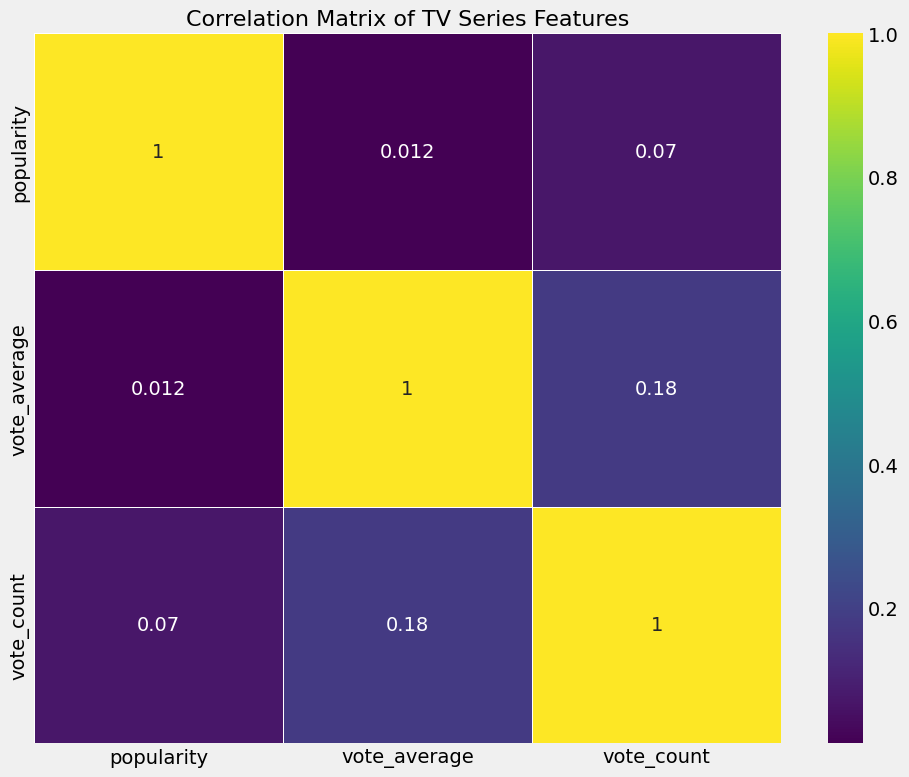

In [19]:
# Create a correlation matrix for numerical features in TV series
series_numeric_cols = ['popularity', 'vote_average', 'vote_count']
series_correlation = series_df[series_numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(series_correlation, annot=True, cmap='viridis', linewidths=0.5)
plt.title('Correlation Matrix of TV Series Features', fontsize=16)
plt.tight_layout()
plt.show()

# Create scatter plot of vote count vs. average rating for TV series

# Interactive scatter plot of vote count vs. average rating

fig = px.scatter(
    series_df.sample(min(1000, len(series_df))),  # Sample to avoid overcrowding
    x='vote_count',
    y='vote_average',
    size='popularity',
    color='release_year',
    hover_name='name',  # Note: TV series use 'name' instead of 'title'
    opacity=0.7,
    title='Series Ratings vs. Vote Count',
    labels={'vote_count': 'Number of Votes', 'vote_average': 'Average Rating', 
           'release_year': 'Release Year', 'popularity': 'Popularity'},
    color_continuous_scale='viridis'
)
fig.update_layout(height=600, width=1000)

C:\Users\cilek\AppData\Local\Temp\ipykernel_58196\1109588227.py:25: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



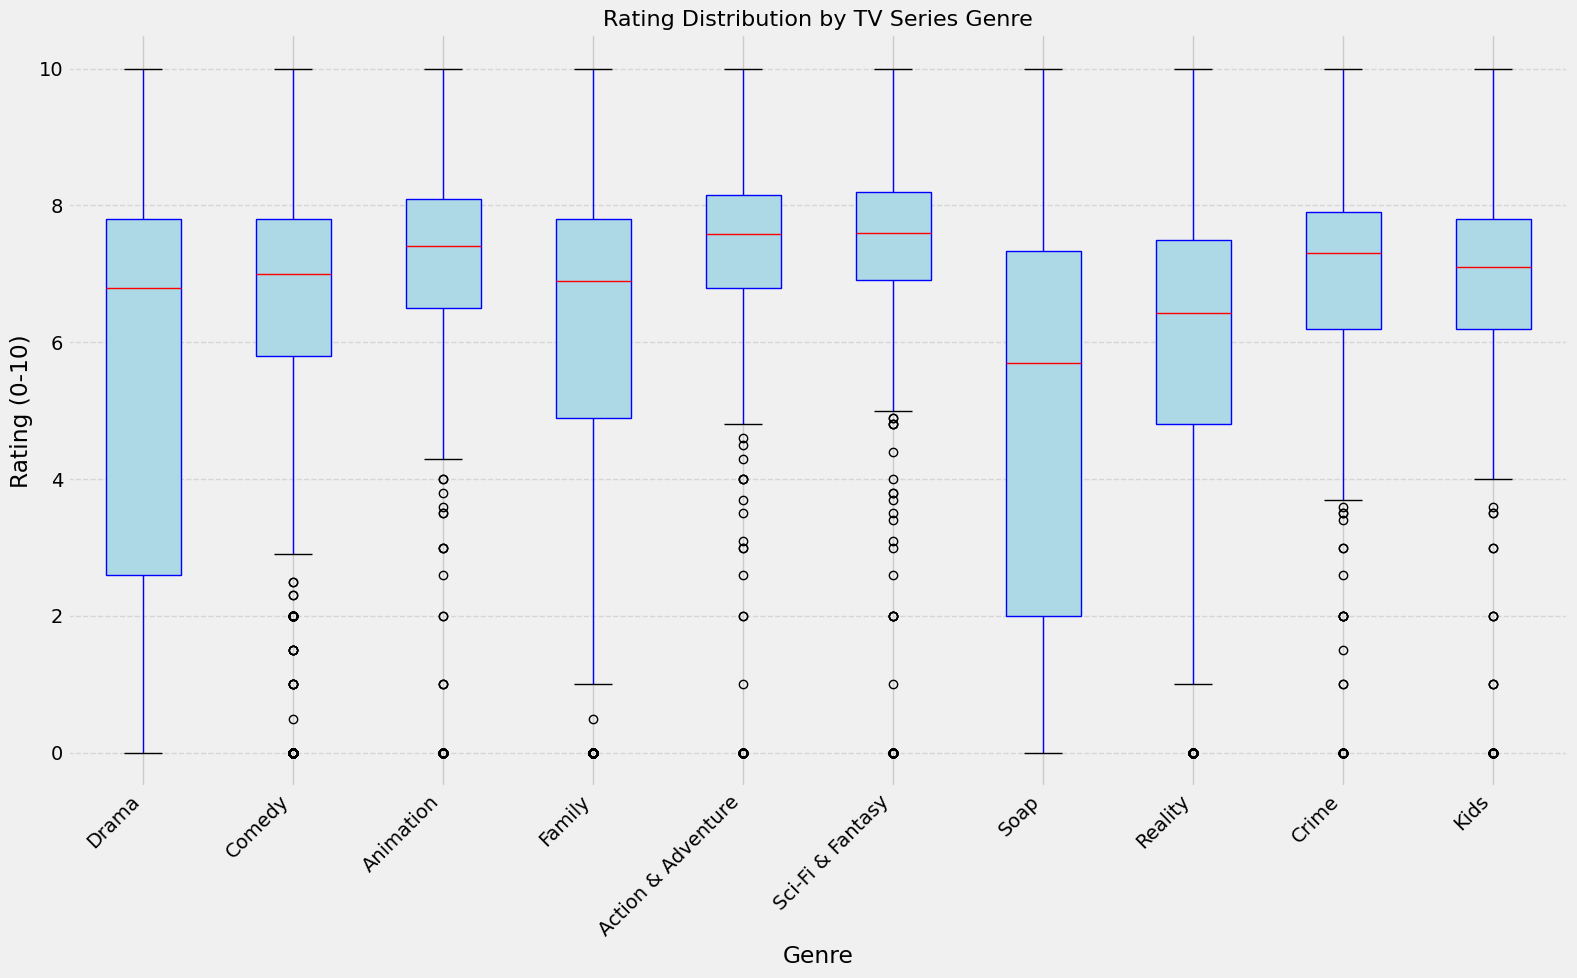

In [20]:
# Genre vs. Rating Analysis for TV series
plt.figure(figsize=(16, 10))

# Get the most common genres for TV series
top_series_genres = pd.DataFrame(Counter(all_series_genres).most_common(10), 
                               columns=['Genre', 'Count'])['Genre'].tolist()

# Create a list to store genre ratings data
series_genre_ratings = []

# Collect ratings for each top genre
for genre in top_series_genres:
    # Find all series containing this genre
    genre_series = series_df[series_df['genre_names'].apply(lambda x: genre in x)]
    # Store the genre and its ratings
    series_genre_ratings.append({
        'genre': genre,
        'ratings': genre_series['vote_average'].tolist()
    })

    # Create boxplot
series_box_data = [item['ratings'] for item in series_genre_ratings]
series_box_labels = [item['genre'] for item in series_genre_ratings]

plt.boxplot(series_box_data, labels=series_box_labels, patch_artist=True, 
           boxprops=dict(facecolor='lightblue', color='blue'),
           whiskerprops=dict(color='blue'),
           medianprops=dict(color='red'))

plt.title('Rating Distribution by TV Series Genre', fontsize=16)
plt.ylabel('Rating (0-10)')
plt.xlabel('Genre')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

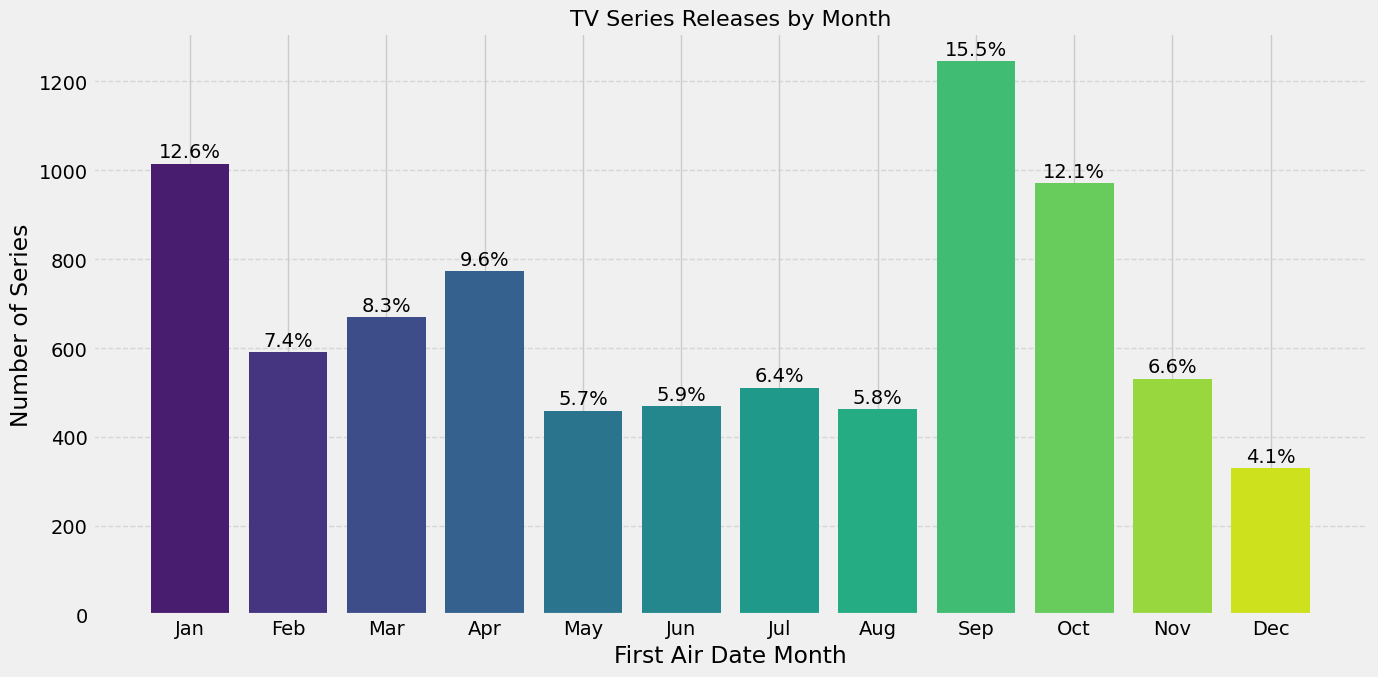

In [21]:
# Seasonal release patterns for TV series
series_df['release_month'] = series_df['first_air_date'].dt.month
series_month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
series_month_counts = series_df['release_month'].value_counts().sort_index()

plt.figure(figsize=(14, 7))
bars = plt.bar(range(1, 13), [series_month_counts.get(i, 0) for i in range(1, 13)], 
              color=sns.color_palette('viridis', 12))
plt.xticks(range(1, 13), series_month_names)
plt.xlabel('First Air Date Month')
plt.ylabel('Number of Series')
plt.title('TV Series Releases by Month', fontsize=16)

# Add percentage on top of bars
total = series_month_counts.sum()
for bar, count in zip(bars, [series_month_counts.get(i, 0) for i in range(1, 13)]):
    percentage = f"{count/total*100:.1f}%"
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 5,
        percentage,
        ha='center',
        va='bottom'
    )

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [22]:
# DETAILED TV SERIES ANALYSIS
print("\n" + "="*50)
print("DETAILED TV SERIES ANALYSIS")
print("="*50)

# Exploring detailed series data
detailed_series = list(db.detailed_series.find())
detailed_series_df = pd.DataFrame(detailed_series)

print(f"Number of series with detailed information: {len(detailed_series_df)}")
print(f"Columns in detailed series data: {detailed_series_df.columns.tolist()}")

# Display sample of detailed series data
if len(detailed_series_df) > 0:
    print("\nSample of detailed series data (first 10 fields of first record):")
    for i, (key, value) in enumerate(detailed_series_df.iloc[0].items()):
        if i < 10:
            print(f"{key}: {value}")


DETAILED TV SERIES ANALYSIS
Number of series with detailed information: 8596
Columns in detailed series data: ['_id', 'adult', 'backdrop_path', 'created_by', 'episode_run_time', 'first_air_date', 'genres', 'homepage', 'id', 'in_production', 'languages', 'last_air_date', 'last_episode_to_air', 'name', 'next_episode_to_air', 'networks', 'number_of_episodes', 'number_of_seasons', 'origin_country', 'original_language', 'original_name', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'seasons', 'spoken_languages', 'status', 'tagline', 'type', 'vote_average', 'vote_count', 'credits', 'keywords', 'similar', 'videos']

Sample of detailed series data (first 10 fields of first record):
_id: 67d821196df8a70f77508057
adult: False
backdrop_path: /gMMnf8VRg3Z98WaFmOLr9Jk8pIs.jpg
created_by: [{'id': 1944474, 'credit_id': '6311a64b3a340b0092198518', 'name': 'Chris Licht', 'original_name': 'Chris Licht', 'gender': 2, 'profile_path': None}, {'id': 1236609, 'cred

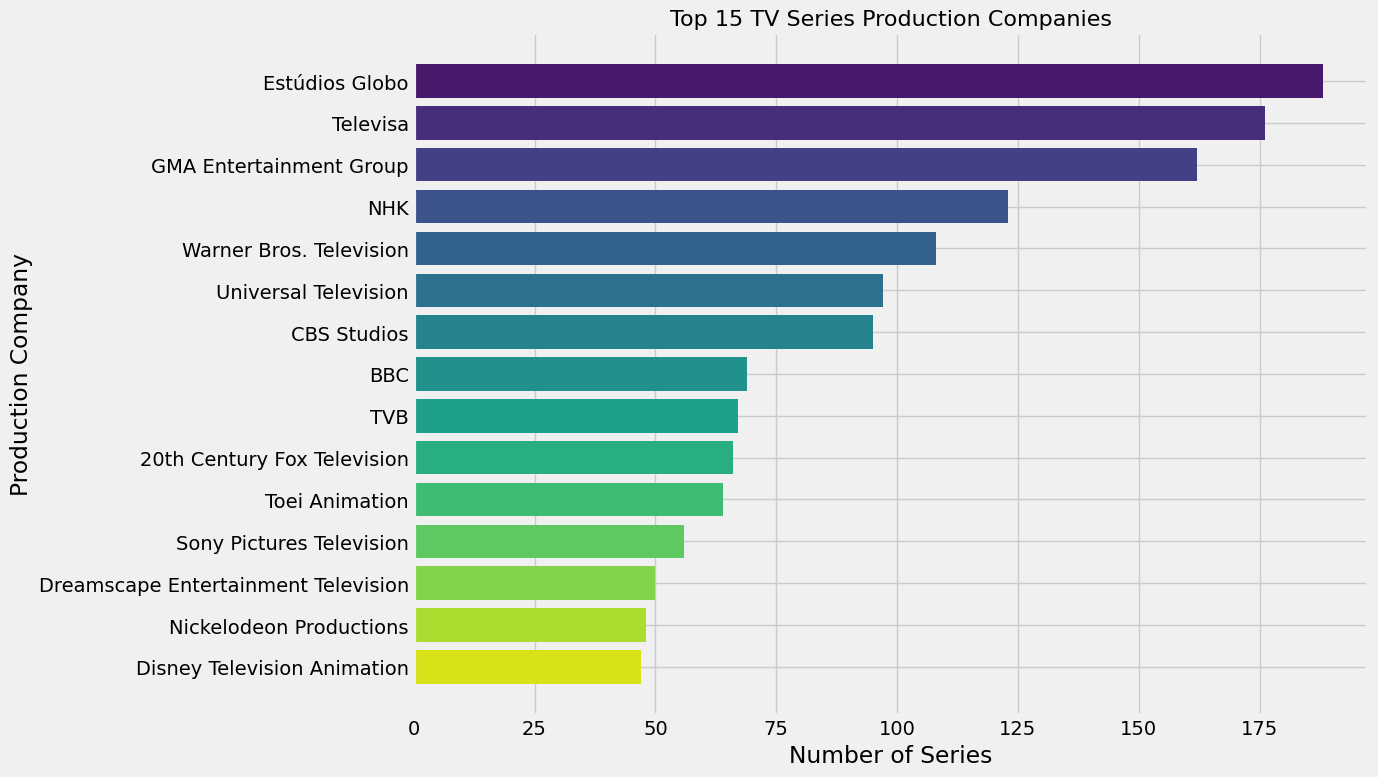

In [23]:
# Analyze production companies
if 'production_companies' in detailed_series_df.columns:
    # Extract production company names
    all_series_companies = []
    for companies in detailed_series_df['production_companies']:
        if isinstance(companies, list):
            for company in companies:
                if isinstance(company, dict) and 'name' in company:
                    all_series_companies.append(company['name'])
    
    # Count companies
    series_company_counts = Counter(all_series_companies).most_common(15)
    series_company_df = pd.DataFrame(series_company_counts, columns=['Company', 'Count'])
    
    plt.figure(figsize=(14, 8))
    bars = plt.barh(series_company_df['Company'], series_company_df['Count'], 
                    color=sns.color_palette('viridis', len(series_company_df)))
    plt.xlabel('Number of Series')
    plt.ylabel('Production Company')
    plt.title('Top 15 TV Series Production Companies', fontsize=16)
    plt.gca().invert_yaxis()  # Invert y-axis to show most common at top
    plt.tight_layout()
    plt.show()

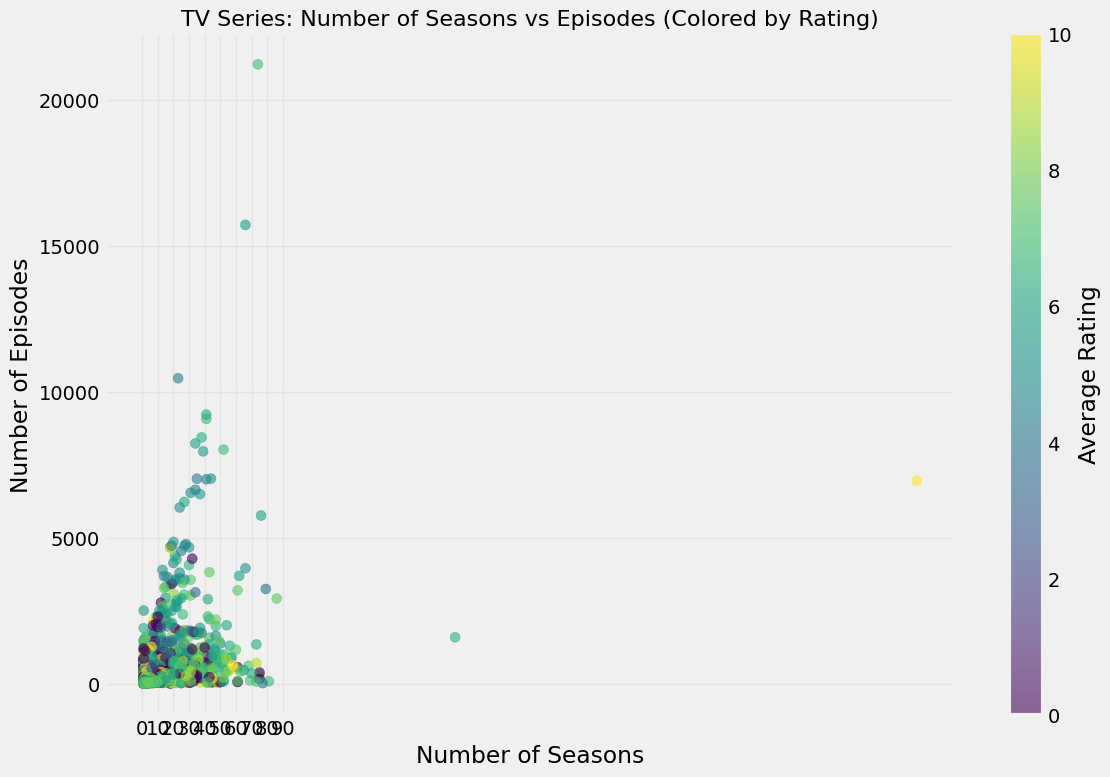

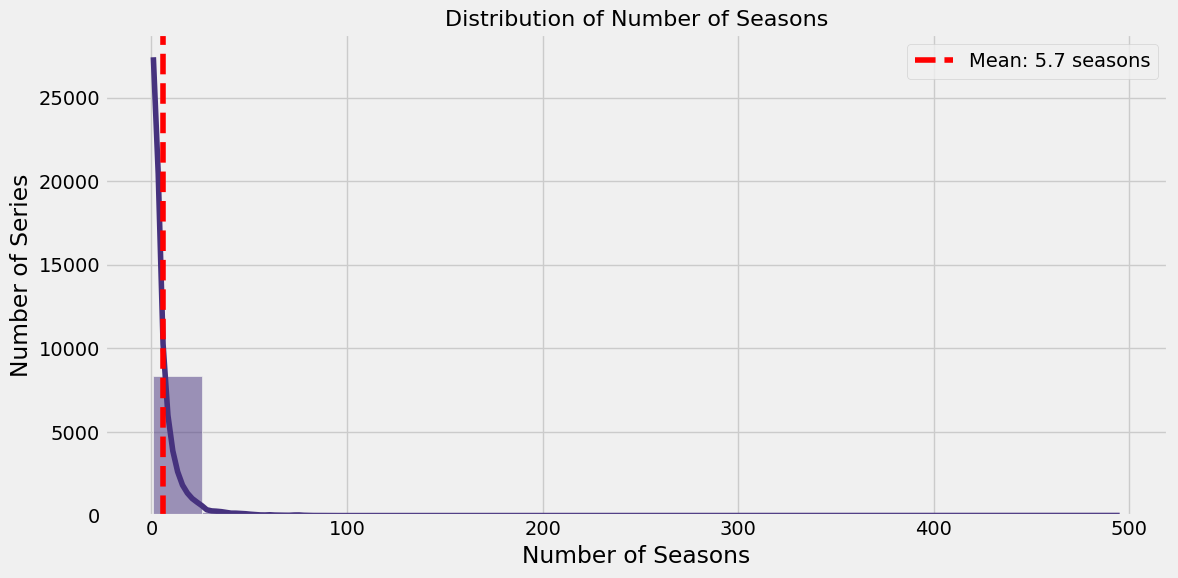

C:\Users\cilek\AppData\Local\Temp\ipykernel_58196\3855512583.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



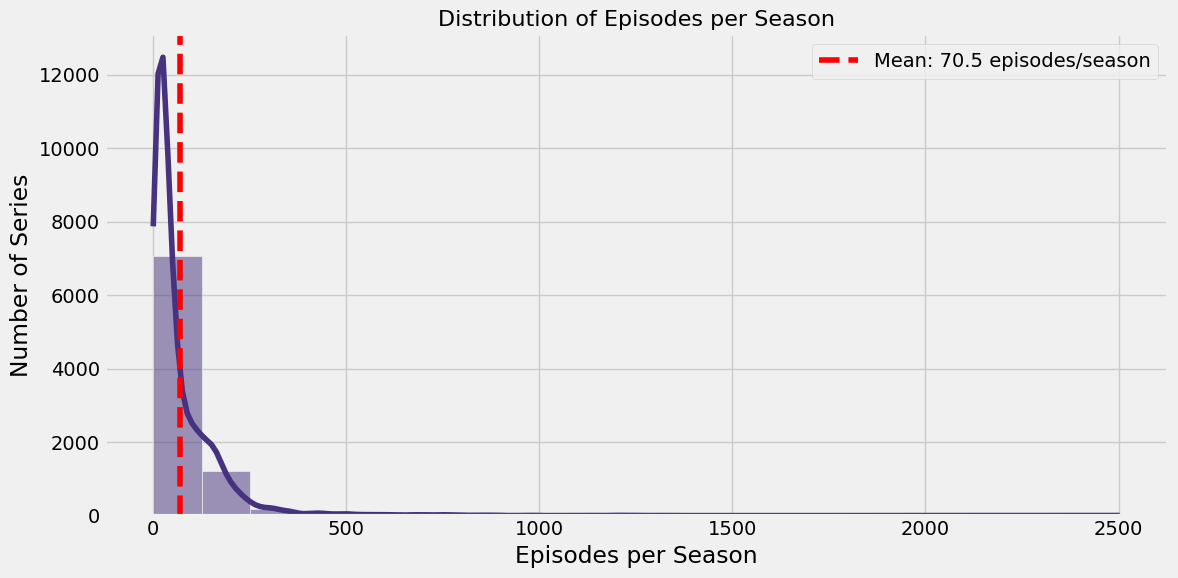

In [ ]:
# Analyze number of seasons and episodes
if 'number_of_seasons' in detailed_series_df.columns and 'number_of_episodes' in detailed_series_df.columns:
    # Filter out zero values
    seasons_episodes_df = detailed_series_df[
        (detailed_series_df['number_of_seasons'] > 0) & 
        (detailed_series_df['number_of_episodes'] > 0)
    ]
    
    # Create scatterplot of seasons vs episodes
    plt.figure(figsize=(12, 8))
    plt.scatter(seasons_episodes_df['number_of_seasons'], 
                seasons_episodes_df['number_of_episodes'], 
                alpha=0.6, 
                c=seasons_episodes_df['vote_average'], 
                cmap='viridis', 
                s=50)
    plt.colorbar(label='Average Rating')
    plt.xlabel('Number of Seasons')
    plt.ylabel('Number of Episodes')
    plt.title('TV Series: Number of Seasons vs Episodes (Colored by Rating)', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Create histogram of number of seasons
    plt.figure(figsize=(12, 6))
    sns.histplot(seasons_episodes_df['number_of_seasons'], bins=20, kde=True)
    plt.axvline(seasons_episodes_df['number_of_seasons'].mean(), color='red', linestyle='--', 
               label=f'Mean: {seasons_episodes_df["number_of_seasons"].mean():.1f} seasons')
    plt.xlabel('Number of Seasons')
    plt.ylabel('Number of Series')
    plt.title('Distribution of Number of Seasons', fontsize=16)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Create histogram of episodes per season
    seasons_episodes_df['episodes_per_season'] = seasons_episodes_df['number_of_episodes'] / seasons_episodes_df['number_of_seasons']
    
    plt.figure(figsize=(12, 6))
    sns.histplot(seasons_episodes_df['episodes_per_season'], bins=20, kde=True)
    plt.axvline(seasons_episodes_df['episodes_per_season'].mean(), color='red', linestyle='--', 
               label=f'Mean: {seasons_episodes_df["episodes_per_season"].mean():.1f} episodes/season')
    plt.xlabel('Episodes per Season')
    plt.ylabel('Number of Series')
    plt.title('Distribution of Episodes per Season', fontsize=16)
    plt.legend()
    plt.tight_layout()
    plt.show()

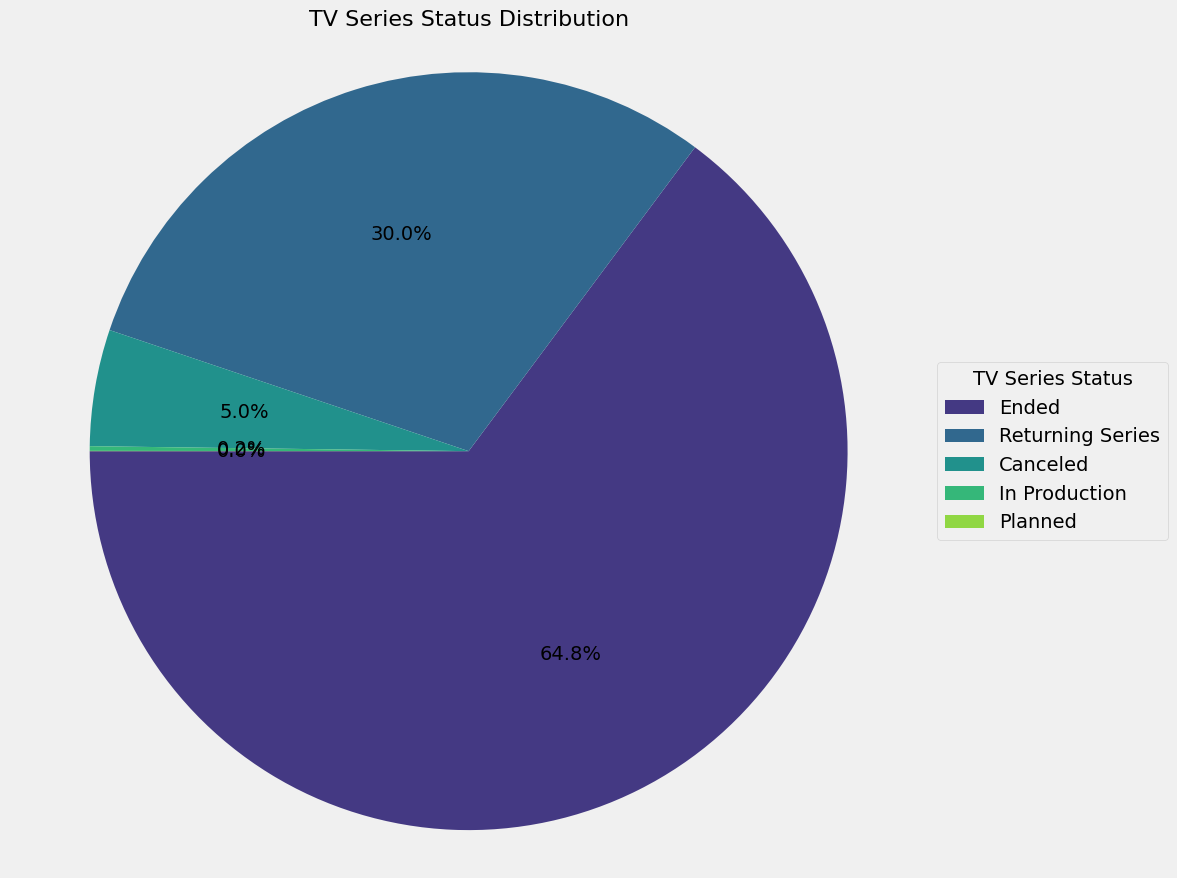

In [25]:
# Analyze series status (in production, ended, etc.)
if 'status' in detailed_series_df.columns:
    status_counts = detailed_series_df['status'].value_counts()

    
    
    plt.figure(figsize=(12, 9))
    plt.pie(status_counts, autopct='%1.1f%%', 
            startangle=180, colors=sns.color_palette('viridis', len(status_counts)))
    plt.legend(status_counts.index, title="TV Series Status", loc="center left", bbox_to_anchor=(1, 0.5))
    plt.axis('equal')
    plt.title('TV Series Status Distribution', fontsize=16)
    plt.tight_layout()
    plt.show()

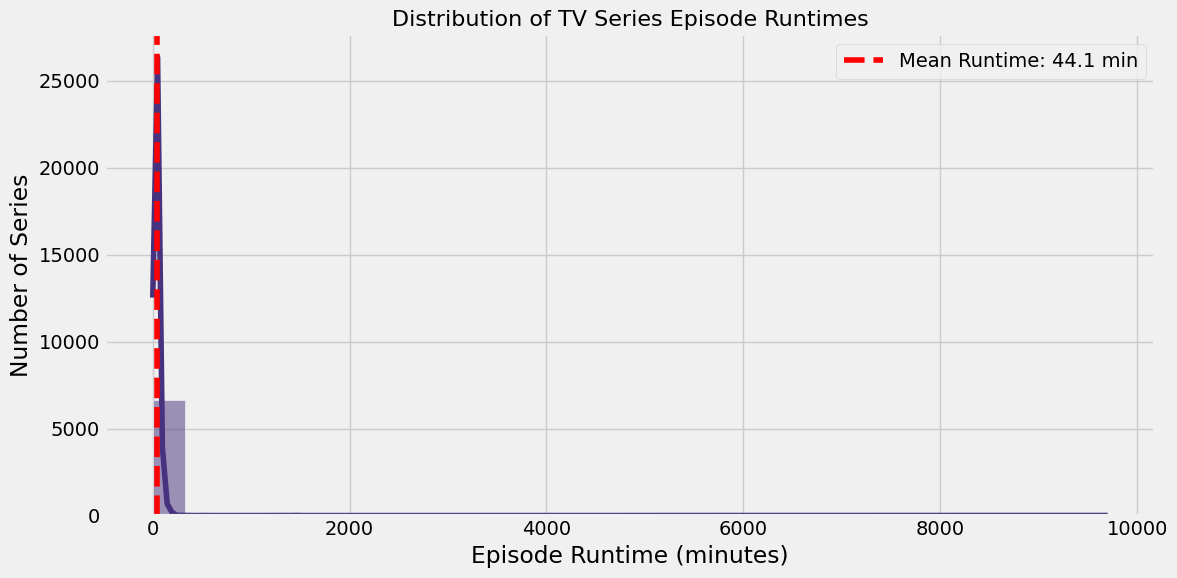

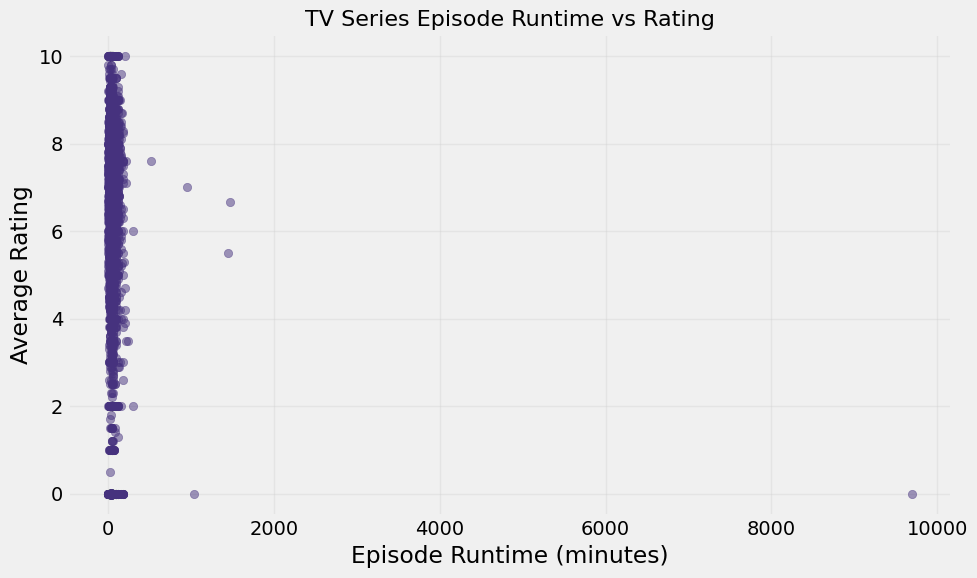

In [27]:
# Analyze runtime distribution
if 'episode_run_time' in detailed_series_df.columns:
    # Extract the first runtime value from each list (if available)
    detailed_series_df['runtime'] = detailed_series_df['episode_run_time'].apply(
        lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None
    )
    
    # Filter out null runtimes
    runtime_series_df = detailed_series_df[detailed_series_df['runtime'].notna()]
    
    plt.figure(figsize=(12, 6))
    sns.histplot(runtime_series_df['runtime'], bins=30, kde=True)
    plt.axvline(runtime_series_df['runtime'].mean(), color='red', linestyle='--', 
               label=f'Mean Runtime: {runtime_series_df["runtime"].mean():.1f} min')
    plt.xlabel('Episode Runtime (minutes)')
    plt.ylabel('Number of Series')
    plt.title('Distribution of TV Series Episode Runtimes', fontsize=16)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Analyze runtime vs rating
    plt.figure(figsize=(10, 6))
    plt.scatter(runtime_series_df['runtime'], runtime_series_df['vote_average'], alpha=0.5)
    plt.xlabel('Episode Runtime (minutes)')
    plt.ylabel('Average Rating')
    plt.title('TV Series Episode Runtime vs Rating', fontsize=16)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

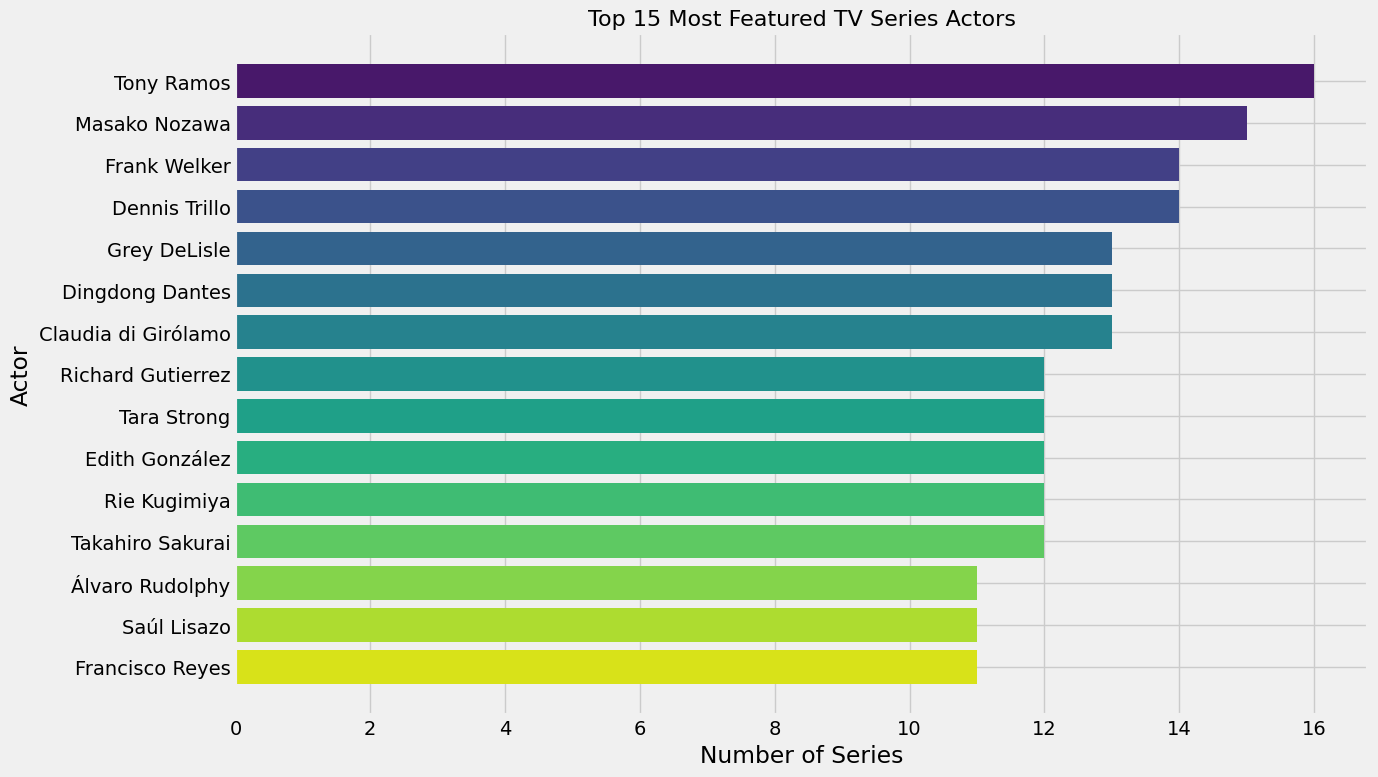

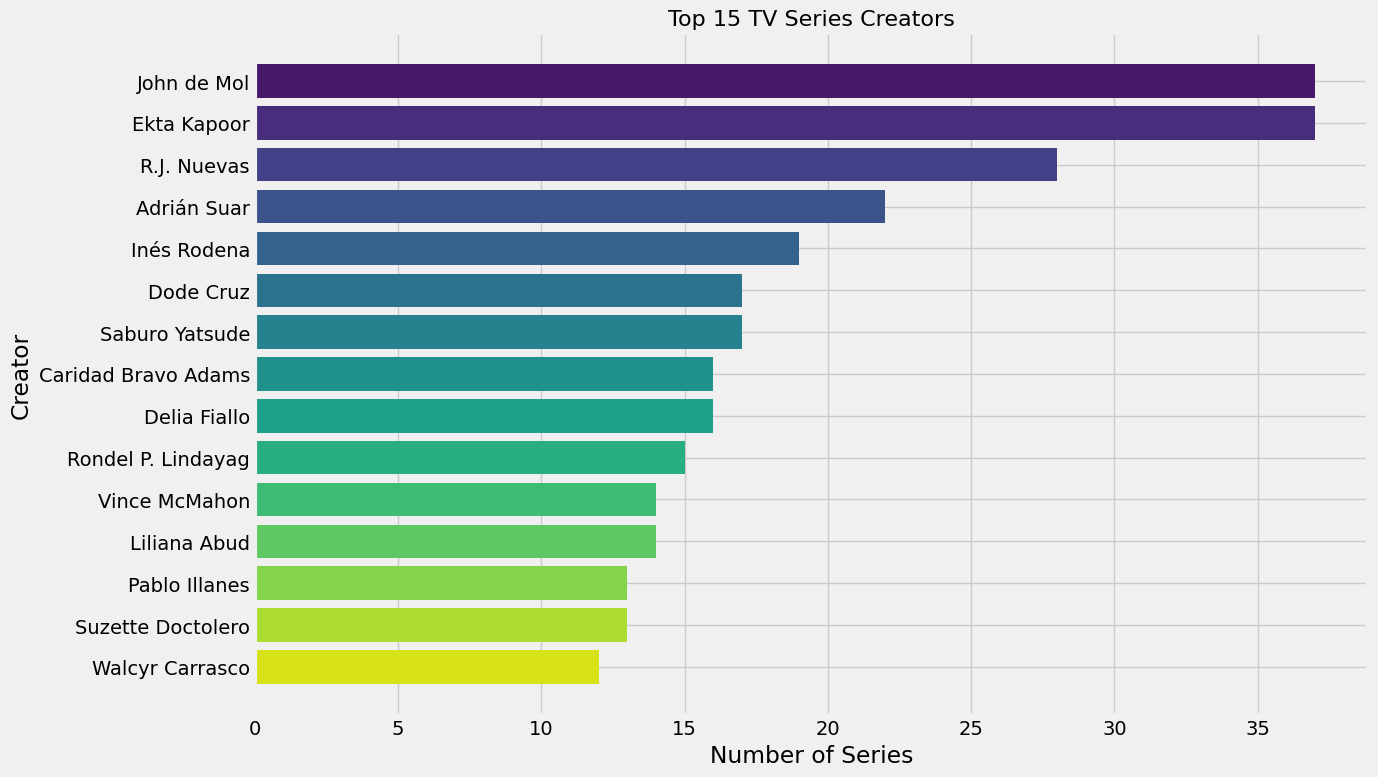

In [28]:
# Analyze series credits/cast
if 'credits' in detailed_series_df.columns and detailed_series_df['credits'].notna().any():
    # Extract top actors
    all_series_actors = []
    for _, series in detailed_series_df.iterrows():
        if isinstance(series['credits'], dict) and 'cast' in series['credits']:
            for actor in series['credits']['cast'][:3]:  # Consider top 3 actors per series
                if isinstance(actor, dict) and 'name' in actor:
                    all_series_actors.append(actor['name'])
    
    # Count actors
    series_actor_counts = Counter(all_series_actors).most_common(15)
    series_actor_df = pd.DataFrame(series_actor_counts, columns=['Actor', 'Count'])
    
    plt.figure(figsize=(14, 8))
    bars = plt.barh(series_actor_df['Actor'], series_actor_df['Count'], 
                   color=sns.color_palette('viridis', len(series_actor_df)))
    plt.xlabel('Number of Series')
    plt.ylabel('Actor')
    plt.title('Top 15 Most Featured TV Series Actors', fontsize=16)
    plt.gca().invert_yaxis()  # Invert y-axis to show most common at top
    plt.tight_layout()
    plt.show()

    # Extract top creators
    all_creators = []
    for _, series in detailed_series_df.iterrows():
        if 'created_by' in series and isinstance(series['created_by'], list):
            for creator in series['created_by']:
                if isinstance(creator, dict) and 'name' in creator:
                    all_creators.append(creator['name'])
    
    # Count creators
    creator_counts = Counter(all_creators).most_common(15)
    creator_df = pd.DataFrame(creator_counts, columns=['Creator', 'Count'])
    
    if len(creator_df) > 0:
        plt.figure(figsize=(14, 8))
        bars = plt.barh(creator_df['Creator'], creator_df['Count'], 
                       color=sns.color_palette('viridis', len(creator_df)))
        plt.xlabel('Number of Series')
        plt.ylabel('Creator')
        plt.title('Top 15 TV Series Creators', fontsize=16)
        plt.gca().invert_yaxis()  # Invert y-axis to show most common at top
        plt.tight_layout()
        plt.show()


COMPARISON: MOVIES VS TV SERIES


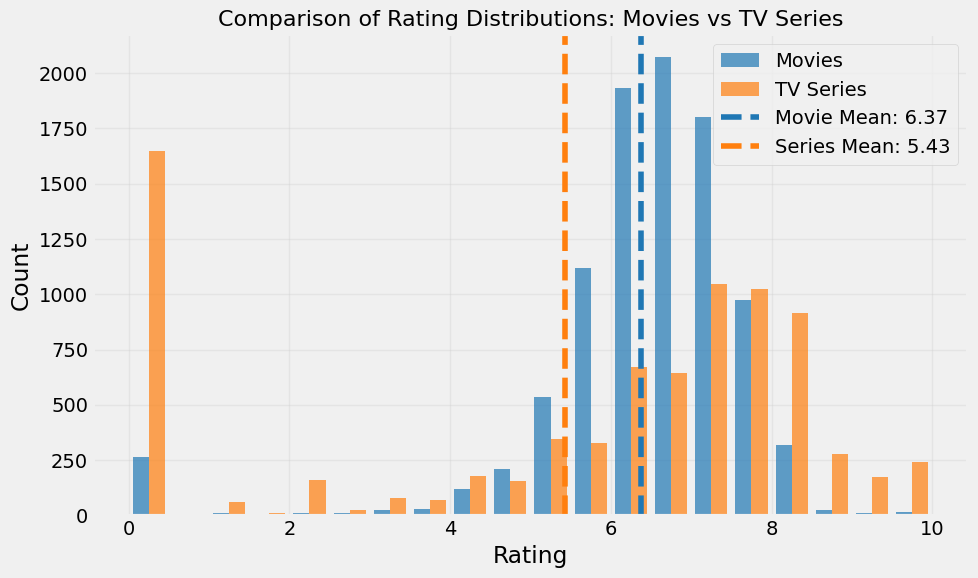

In [29]:
# COMPARISON BETWEEN MOVIES AND TV SERIES
print("\n" + "="*50)
print("COMPARISON: MOVIES VS TV SERIES")
print("="*50)

# Compare average ratings
plt.figure(figsize=(10, 6))
movie_ratings = movies_df['vote_average']
series_ratings = series_df['vote_average']

plt.hist([movie_ratings, series_ratings], bins=20, 
         label=['Movies', 'TV Series'], alpha=0.7, 
         color=['#1f77b4', '#ff7f0e'])
plt.axvline(movie_ratings.mean(), color='#1f77b4', linestyle='--', 
           label=f'Movie Mean: {movie_ratings.mean():.2f}')
plt.axvline(series_ratings.mean(), color='#ff7f0e', linestyle='--', 
           label=f'Series Mean: {series_ratings.mean():.2f}')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Comparison of Rating Distributions: Movies vs TV Series', fontsize=16)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

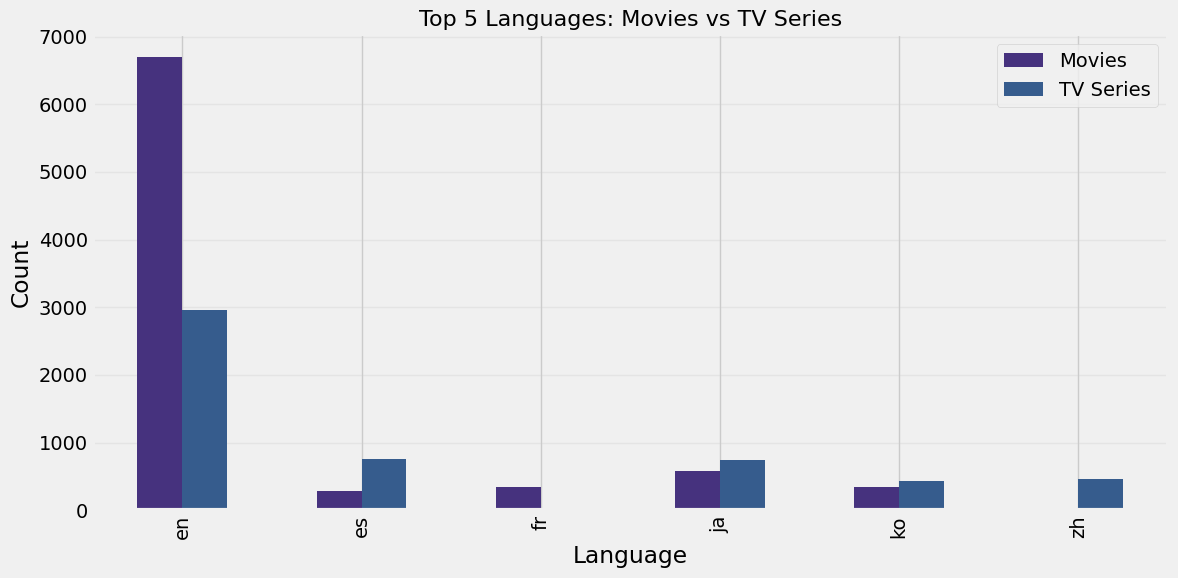

In [30]:
# Compare language distributions
movie_langs = movies_df['original_language'].value_counts().head(5)
series_langs = series_df['original_language'].value_counts().head(5)

# Create a combined dataframe
langs_df = pd.DataFrame({
    'Movies': movie_langs,
    'TV Series': series_langs
})
langs_df.fillna(0, inplace=True)

plt.figure(figsize=(12, 6))
langs_df.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Language')
plt.ylabel('Count')
plt.title('Top 5 Languages: Movies vs TV Series', fontsize=16)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

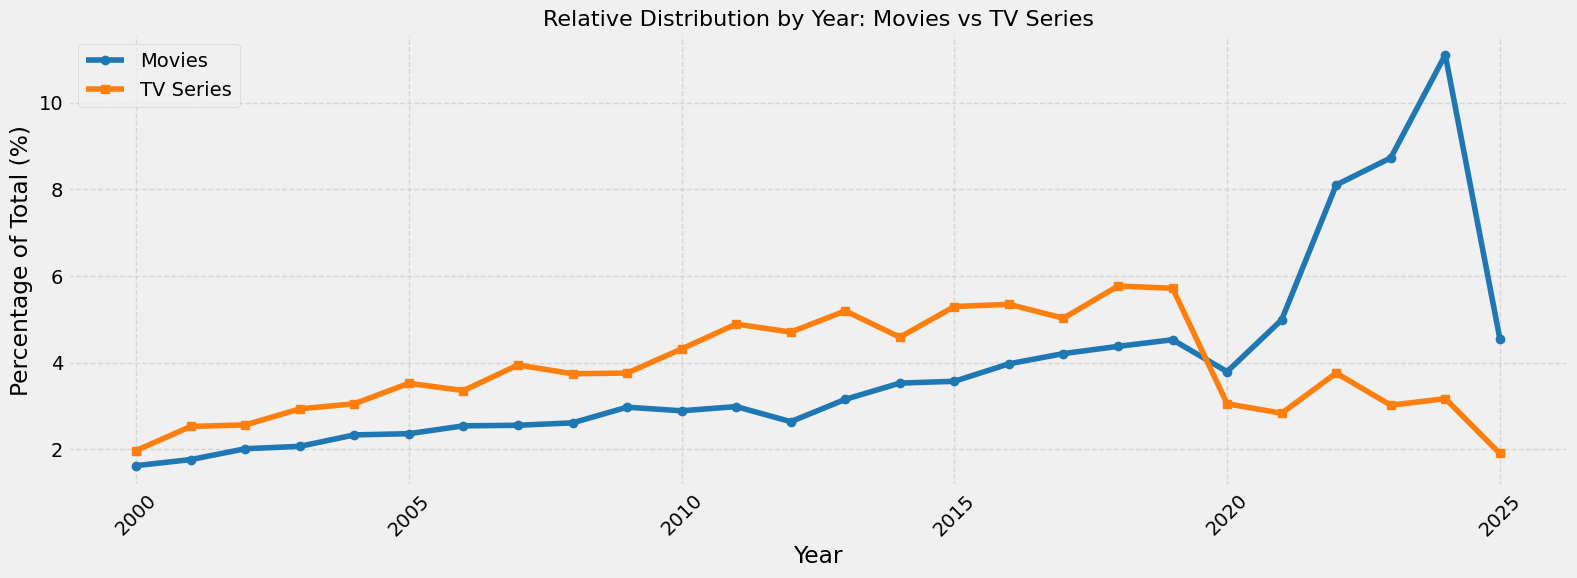

In [31]:
# Compare popularity over years
# Create year-based dataframes
movie_years = movies_df.groupby('release_year').size()
series_years = series_df.groupby('release_year').size()

# Filter for recent years with sufficient data
recent_years = range(2000, datetime.now().year + 1)
movie_years = movie_years.reindex(recent_years, fill_value=0)
series_years = series_years.reindex(recent_years, fill_value=0)

# Normalize to percentages of total for fair comparison
movie_years_pct = movie_years / movie_years.sum() * 100
series_years_pct = series_years / series_years.sum() * 100

plt.figure(figsize=(16, 6))
plt.plot(movie_years_pct.index, movie_years_pct.values, marker='o', 
         linestyle='-', label='Movies', color='#1f77b4')
plt.plot(series_years_pct.index, series_years_pct.values, marker='s', 
         linestyle='-', label='TV Series', color='#ff7f0e')
plt.xlabel('Year')
plt.ylabel('Percentage of Total (%)')
plt.title('Relative Distribution by Year: Movies vs TV Series', fontsize=16)
plt.xticks(range(min(recent_years), max(recent_years)+1, 5), rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

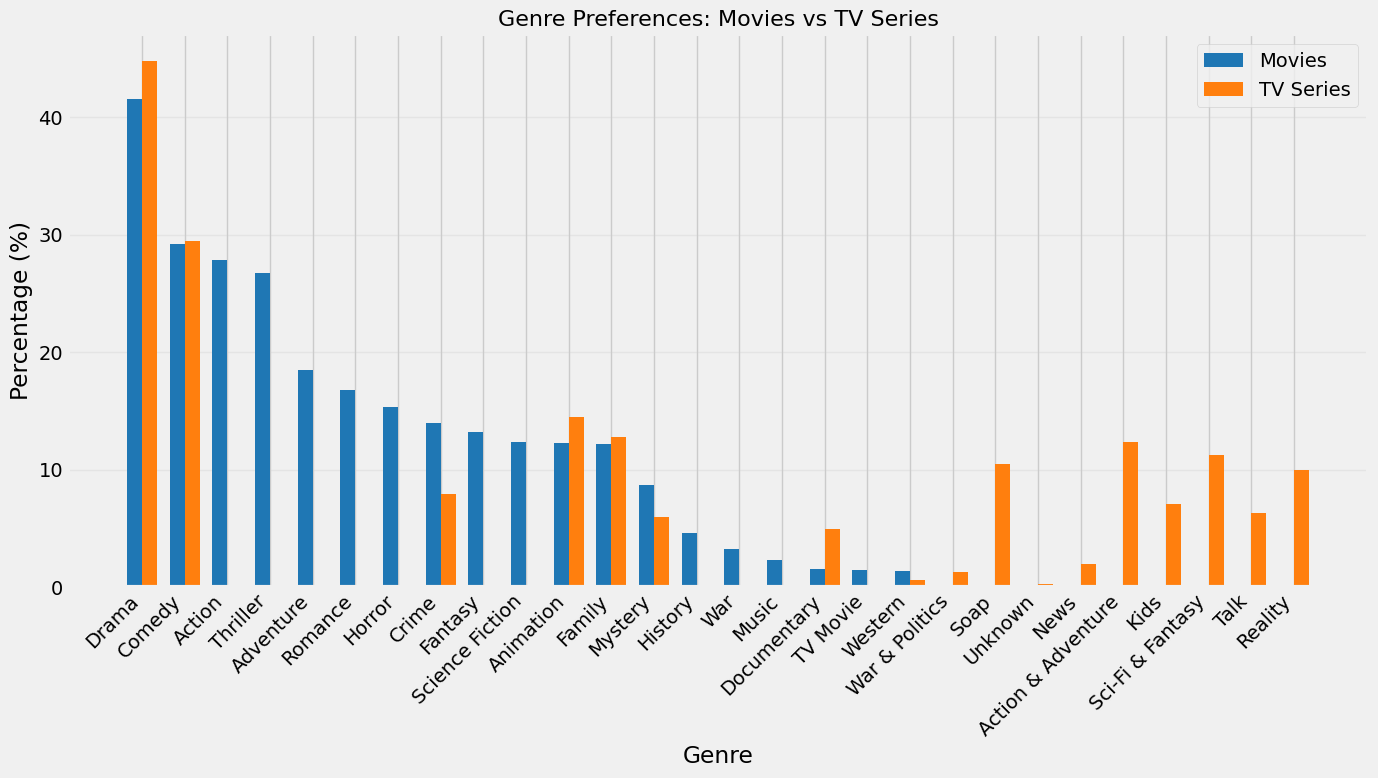

In [32]:
# Compare genre preferences
# Get top genres for both
movie_genres_top = Counter(all_genres)
series_genres_top = Counter(all_series_genres)

# Create dictionaries for easy lookup
movie_genre_dict = dict(movie_genres_top)
series_genre_dict = dict(series_genres_top)

# Get union of top genres
all_top_genres = set(movie_genre_dict.keys()).union(set(series_genre_dict.keys()))

# Create comparison dataframe
genre_compare = []
for genre in all_top_genres:
    movie_count = movie_genre_dict.get(genre, 0)
    series_count = series_genre_dict.get(genre, 0)
    # Calculate percentages
    movie_pct = movie_count / len(movies_df) * 100
    series_pct = series_count / len(series_df) * 100
    genre_compare.append({
        'Genre': genre,
        'Movies (%)': movie_pct,
        'TV Series (%)': series_pct
    })

genre_compare_df = pd.DataFrame(genre_compare)
genre_compare_df = genre_compare_df.sort_values('Movies (%)', ascending=False)

# Plot the comparison
plt.figure(figsize=(14, 8))
bar_width = 0.35
x = np.arange(len(genre_compare_df))

plt.bar(x - bar_width/2, genre_compare_df['Movies (%)'], bar_width, 
       label='Movies', color='#1f77b4')
plt.bar(x + bar_width/2, genre_compare_df['TV Series (%)'], bar_width, 
       label='TV Series', color='#ff7f0e')

plt.xlabel('Genre')
plt.ylabel('Percentage (%)')
plt.title('Genre Preferences: Movies vs TV Series', fontsize=16)
plt.xticks(x, genre_compare_df['Genre'], rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()